# National Electricity System Operator (NESO) Data

### Main data source

from kaggle, as included here: https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data

in its native origin, uncombined with the 2024 file updated daily: https://www.neso.energy/data-portal/historic-demand-data

### Additional Sources

<b><font color=#ce445d>list of dates when clocks change:</b> https://www.metalsmine.com/calendar/400-uk-daylight-saving-time-shift

<b><font color=#ce445d>population estimates:</b> https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland
(Mid 2011-Mid 2022)

<b><font color=#ce445d>GeoJSON map of Europe</b>: https://github.com/leakyMirror/map-of-europe/tree/master

<b><font color=#ce445d>GeoJSON maps to separate UK countries</b>:

**England**: https://cartographyvectors.com/map/1321-england-uk

**Wales**: https://cartographyvectors.com/map/1320-wales-uk

**Scotland**: https://cartographyvectors.com/map/1322-scotland-uk

**Northern Ireland**: https://cartographyvectors.com/map/1319-northern-ireland


## Common Abbreviations

**NESO**: National Electricty Systems Operator

**ESO**: Electricity System Operator

**MW**: MegaWatts

## Column Overview

**settlement_date**: date

**settlement_period**: half hourly period number (1 = 00:00, 2 = 00:30... 48 = 23:30)

**nd**: (National Demand). Sum of metered generation, excluding generation required to meet station load, pump storage pumping and interconnector exports. ND is calculated as a sum of generation based on National Grid ESO operationl generation metering. Measured in MW.

**tsd**: (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW

**england_wales_demand**: England and Wales Demand, as ND above but on an England and Wales basis. Measured in MW

**embedded_wind_generation**: This is an estimate of the GB wind generation from wind farms which do not have Transmission System metering installed. These wind farms are embedded in the distribution network and invisible to National Grid ESO. Their effect is to suppress the electricity demand during periods of high wind. The true output of these generators is not known so an estimate is provided based on National Grid ESO’s best model. Measured in MW.

**embedded_wind_capacity**: This is National Grid ESO’s best view of the installed embedded wind capacity in GB. This is based on publicly available information compiled from a variety of sources and is not the definitive view. It is consistent with the generation estimate provided above. Measured in MW.

**embedded_solar_generation**: This is an estimate of the GB solar generation from PV panels. These are embedded in the distribution network and invisible to National Grid ESO. Their effect is to suppress the electricity demand during periods of high radiation. The true output of these generators is not known so an estimate is provided based on National Grid ESO’s best model. Measured in MW.

**embedded_solar_capacity**: As embedded wind capacity above, but for solar generation. Measured in MW.

**non_bm_stor**: (Non-Balancing Mechanism SHort-Term Operating Reserve). For units that are not included in the ND generator definition. This can be in the form of generation or demand reduction. Measured in MW.

**pump_storage_pumping**: The demand due to pumping at hydro pump storage units; the -ve signifies pumping load.

**"xxxxx_flow**: Flow on respective interconnector. Negative signifies export power out from GB; positive signifies import power into GB. Measured in MW. 

Below are the locations connected to GB via the named interconnector:
NB: where there are NaN values in these columns, it means the interconnector was commissioned after the start of the data.

____**ifa**: France (Interconnexion France-Angleterre)

____**ifa2**: France

____**britned**: Netherlands

____**moyle**: Norther Ireland

____**east_west**: Ireland

____**nemo**: Belgium

____**nsl**: Norway (North Sea Link), commissioned in 2021

____**eleclink**: France, commissioned in 2021

____**viking**: Denmark, commissioned in 2024

**scottish_transfer** an interconnector able to send power quickly between Scotland and England. Since both Scotland and England are included in the nd and tsd data, I am not considering this an international interconnector. Commissioned in 2024.

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from bokeh.plotting import figure, output_notebook, show, save
from bokeh.models import ColumnDataSource, HoverTool
import datetime


In [3]:
# set plot palette & default style
pigeon = ["#6C3483", "#00796B", "#C33D4A", "#F4B632", "#103C64" ]
custom_palette = sns.set_palette(sns.color_palette(pigeon))

#set colours for seasons
season_palette = ['#C56B4E', '#7FB77E', '#F4B632', '#2C4C69']
season_colours = {'winter': '#2C4C69', 'spring': '#7FB77E', 'summer': '#F4B632', 'autumn': '#C56B4E',}
wintercolor = '#2C4C69'
autumncolor = '#C56B4E'
springcolor = '#7FB77E'
summercolor = '#F4B632'

sns.set_style({#'axes.grid': True, 
               #"grid.color": "white",
               'axes.facecolor':'#F1F1F1',
               'figure.facecolor':'#F1F1F1',
               'axes.edgecolor' : '#252525', 
               'text.color': '#252525',
               'xtick.color': '#252525',
               'ytick.color': '#252525',
               'image.cmap':'magma',
    'axes.spines.right': False,
    'axes.spines.top': False})

In [4]:
#view more columns
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [5]:
#bring in dataset & take a look
df = pd.read_csv('data/historic_demand_2009_2024.csv')
df.columns = df.columns.str.lower().str.replace(" ", "_")
df = df.drop(columns='unnamed:_0')
print(df.shape)
print(df.index.nunique() == df.shape[0])
display(df.head(2))

(276910, 22)
True


settlement_date  settlement_period     nd    tsd  england_wales_demand  embedded_wind_generation  embedded_wind_capacity  embedded_solar_generation  embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday
0      2009-01-01                  1  37910  38704                 33939                        54                    1403                          0                        0            0                    33      2002          0             0        -161               0          0       NaN            NaN                NaN          NaN           1
1      2009-01-01                  2  38047  38964                 34072                        53                    1403                          0                        0            0                   157      2002          0             0        -160               0          0       NaN            NaN                NaN          NaN           1

# Cleaning & Preparation

In [6]:
#clean dates
df['settlement_date'] = pd.to_datetime(df['settlement_date'])

df['year'] = df['settlement_date'].dt.year
df['month'] = df['settlement_date'].dt.month
df['day'] = df['settlement_date'].dt.day
df['weekday'] = df['settlement_date'].dt.day_name()
df['weekend'] = df['settlement_date'].dt.weekday.isin([5, 6]).astype(int)

df['year_month'] = df['settlement_date'].dt.to_period('M')
df['time'] = df['settlement_date'].dt.time

#remove 2024 data, as 2024 incomplete in source file
df = df[df['year']!=2024]

df.head(1)

settlement_date  settlement_period     nd    tsd  england_wales_demand  embedded_wind_generation  embedded_wind_capacity  embedded_solar_generation  embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  year  month  day   weekday  weekend year_month      time
0      2009-01-01                  1  37910  38704                 33939                        54                    1403                          0                        0            0                    33      2002          0             0        -161               0          0       NaN            NaN                NaN          NaN           1  2009      1    1  Thursday        0    2009-01  00:00:00

In [7]:
#replace 0s & outliers with means
df["tsd"] = df["tsd"].replace(0, np.nan)
df["tsd"] = df["tsd"].ffill().astype(int) #better strategy desired since 0s are clustered

df["england_wales_demand"] = df["england_wales_demand"].replace(0, np.nan) 
df["england_wales_demand"] = df["england_wales_demand"].replace(7654.0, np.nan)
df["england_wales_demand"] = df["england_wales_demand"].ffill().astype(int) #ffill good strategy for this col as 0s are sporadic

#add scotland column
df.loc[:, "scot_demand"] = df['nd'] - df['england_wales_demand']

#clean column names
df.columns = df.columns.str.replace("embedded_", "")
df.columns = df.columns.str.replace("settlement_", "")
df = df.rename(columns = {"england_wales_demand":"eng_wal_demand", "pump_storage_pumping":"pump"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262944 entries, 0 to 262943
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               262944 non-null  datetime64[ns]
 1   period             262944 non-null  int64         
 2   nd                 262944 non-null  int64         
 3   tsd                262944 non-null  int32         
 4   eng_wal_demand     262944 non-null  int32         
 5   wind_generation    262944 non-null  int64         
 6   wind_capacity      262944 non-null  int64         
 7   solar_generation   262944 non-null  int64         
 8   solar_capacity     262944 non-null  int64         
 9   non_bm_stor        262944 non-null  int64         
 10  pump               262944 non-null  int64         
 11  ifa_flow           262944 non-null  int64         
 12  ifa2_flow          262944 non-null  int64         
 13  britned_flow       262944 non-null  int64        

In [8]:
#cleaning periods & times on dates where clocks changed

#List of dates clocks changed. Source:  https://www.metalsmine.com/calendar/400-uk-daylight-saving-time-shift
clocks = pd.read_excel('data/clock_changes.xlsx')
clocks = clocks.drop([0, 1, 32, 33, 34, 35])
clocks = clocks.drop(columns=['Expected Impact / Date'])

spring = clocks[clocks['month'] == "mar"]
sf_dates = spring['date'].to_list()

autumn = clocks[clocks['month'] == "oct"]
fb_dates = autumn['date'].to_list()

#create dfs containing only spring forward/fall back dates
df_spring = df[df['date'].isin(sf_dates)]
df_autumn = df[df['date'].isin(fb_dates)]

#remove spring forward/fall back dates from dataframe
df = df[~df['date'].isin(sf_dates)]
df = df[~df['date'].isin(fb_dates)]

sf_time_df = pd.read_excel('data/spring_fall_times.xlsx', 'sf')
display(sf_time_df.head())

fb_time_df = pd.read_excel('data/spring_fall_times.xlsx', 'fb')
display(fb_time_df.head(7))

# create dicts from dfs
sf_period_dict = dict(zip(sf_time_df['sf_orig'].to_list(), sf_time_df['sf_change'].to_list()))
fb_period_dict = dict(zip(fb_time_df['fb_orig'].to_list(), fb_time_df['fb_change'].to_list()))

#map dict values to dfs
df_spring.loc[:, 'period'] = df_spring['period'].map(sf_period_dict)
display(df_spring.head(6))
print(df_spring.shape)

df_autumn.loc[:, 'period'] = df_autumn['period'].map(fb_period_dict)
display(df_autumn.head(6))
print(df_autumn.shape)

#renerge dataframes
df = pd.concat([df, df_spring, df_autumn], ignore_index=False)

sf_orig  sf_change
0        1          1
1        2          2
2        3          5
3        4          6
4        5          7

fb_orig  fb_change
0        1          1
1        2          2
2        3          3
3        4          4
4        5          3
5        6          4
6        7          5

date  period     nd    tsd  eng_wal_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  year  month  day weekday  weekend year_month      time  scot_demand
4176 2009-03-29       1  32556  34546           29046              583           1419                 0               0            0  1144      1772          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3510
4177 2009-03-29       2  32334  34319           28951              568           1419                 0               0            0  1139      1772          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3383
4178 2009-03-29       5  31983  34021           28637              568           1419                 0               0            0  1292      1772          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3346
4179 2009-03-29       6  31605  33586           28243              557           1419                 0               0            0  1235      1773          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3362
4180 2009-03-29       7  31235  33233           27746              557           1419                 0               0            0  1251      1772          0             0        -247               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3489
4181 2009-03-29       8  30769  32849           27237              499           1419                 0               0            0  1333      1772          0             0        -247               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3532

(690, 30)


date  period     nd    tsd  eng_wal_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  year  month  day weekday  weekend year_month      time  scot_demand
14254 2009-10-25       1  26115  27753           23316             1379           1737                 0               0            0   810      -283          0             0         -45               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2799
14255 2009-10-25       2  24948  26661           22407             1385           1737                 0               0            0   861      -283          0             0         -69               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2541
14256 2009-10-25       3  25518  27274           22843             1385           1737                 0               0            0  1091       331          0             0        -165               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2675
14257 2009-10-25       4  25647  27430           23056             1391           1737                 0               0            0  1117       337          0             0        -166               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2591
14258 2009-10-25       3  24972  26857           22490             1385           1737                 0               0            0  1119       336          0             0        -166               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2482
14259 2009-10-25       4  24308  26174           21816             1391           1737                 0               0            0  1101       337          0             0        -165               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2492

(750, 30)


In [9]:
#add settlement period time to datetime col - each period is half an hour
df['dt'] = df['date'] + pd.to_timedelta((df['period'] - 1)*30, unit='m')
df['dt'] = pd.to_datetime(df['dt'], format= "%Y%m%d %H%M%S")

df['hour'] = df['dt'].dt.hour
df['minute'] = df['dt'].dt.minute

df['time'] = df['dt'].dt.time

In [10]:
#function to easily filter for a date
def datefilter(df, yr, mo, dy):
    return df[(df['year'] == yr) & (df['month'] == mo) & (df['day'] == dy)]


datefilter(df, 2009, 10, 25)

date  period     nd    tsd  eng_wal_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  year  month  day weekday  weekend year_month      time  scot_demand                  dt  hour  minute
14254 2009-10-25       1  26115  27753           23316             1379           1737                 0               0            0   810      -283          0             0         -45               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:00:00         2799 2009-10-25 00:00:00     0       0
14255 2009-10-25       2  24948  26661           22407             1385           1737                 0               0            0   861      -283          0             0         -69               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  00:30:00         2541 2009-10-25 00:30:00     0      30
14256 2009-10-25       3  25518  27274           22843             1385           1737                 0               0            0  1091       331          0             0        -165               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  01:00:00         2675 2009-10-25 01:00:00     1       0
14257 2009-10-25       4  25647  27430           23056             1391           1737                 0               0            0  1117       337          0             0        -166               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  01:30:00         2591 2009-10-25 01:30:00     1      30
14258 2009-10-25       3  24972  26857           22490             1385           1737                 0               0            0  1119       336          0             0        -166               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  01:00:00         2482 2009-10-25 01:00:00     1       0
14259 2009-10-25       4  24308  26174           21816             1391           1737                 0               0            0  1101       337          0             0        -165               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  01:30:00         2492 2009-10-25 01:30:00     1      30
14260 2009-10-25       5  23652  25776           21270             1391           1737                 0               0            0  1358       336          0             0        -166               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  02:00:00         2382 2009-10-25 02:00:00     2       0
14261 2009-10-25       6  23370  25496           20985             1383           1737                 0               0            0  1360       337          0             0        -166               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  02:30:00         2385 2009-10-25 02:30:00     2      30
14262 2009-10-25       7  22860  24978           20500             1383           1737                 0               0            0  1353       336          0             0        -165               0          0       NaN            NaN                NaN          NaN           0  2009     10   25  Sunday        1    2009-10  03:00:00         2360 2009-10-25 03:00:00     3       0
14263 2009-10-25       8  22397  24483           19941             1395           1737                 0               0            0  1344       337   

In [11]:
datefilter(df, 2009, 3, 29)

date  period     nd    tsd  eng_wal_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  viking_flow  is_holiday  year  month  day weekday  weekend year_month      time  scot_demand                  dt  hour  minute
4176 2009-03-29       1  32556  34546           29046              583           1419                 0               0            0  1144      1772          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:00:00         3510 2009-03-29 00:00:00     0       0
4177 2009-03-29       2  32334  34319           28951              568           1419                 0               0            0  1139      1772          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  00:30:00         3383 2009-03-29 00:30:00     0      30
4178 2009-03-29       5  31983  34021           28637              568           1419                 0               0            0  1292      1772          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  02:00:00         3346 2009-03-29 02:00:00     2       0
4179 2009-03-29       6  31605  33586           28243              557           1419                 0               0            0  1235      1773          0             0        -246               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  02:30:00         3362 2009-03-29 02:30:00     2      30
4180 2009-03-29       7  31235  33233           27746              557           1419                 0               0            0  1251      1772          0             0        -247               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  03:00:00         3489 2009-03-29 03:00:00     3       0
4181 2009-03-29       8  30769  32849           27237              499           1419                 0               0            0  1333      1772          0             0        -247               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  03:30:00         3532 2009-03-29 03:30:00     3      30
4182 2009-03-29       9  29946  32019           26504              499           1419                 0               0            0  1326      1772          0             0        -247               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  04:00:00         3442 2009-03-29 04:00:00     4       0
4183 2009-03-29      10  29191  31259           25854              364           1419                 0               0            0  1321      1772          0             0        -247               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  04:30:00         3337 2009-03-29 04:30:00     4      30
4184 2009-03-29      11  28661  30657           25413              364           1419                 0               0            0  1320      1983          0             0        -176               0          0       NaN            NaN                NaN          NaN           0  2009      3   29  Sunday        1    2009-03  05:00:00         3248 2009-03-29 05:00:00     5       0
4185 2009-03-29      12  28453  30396           25249              318           1419                 0               0            0  1315      2002          0  

In [12]:
# interconnector columns
interconnectors = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow']
#three columns representing interconnectors with France
france_ics = ['ifa_flow', 'ifa2_flow', 'eleclink_flow']
non_fr_ics = ['britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow']

In [13]:
#viking flow commissioned in 2024
df = df.drop(columns="viking_flow")

df['in_flow'] = df[interconnectors].apply(lambda x:x[x > 0].sum(), axis=1)
df['out_flow'] = abs(df[interconnectors].apply(lambda x: x[x < 0].sum(), axis=1))
df['total_flow'] = df[interconnectors].sum(axis=1)
#three interconnectors with france
df['france_flow'] = df[france_ics].sum(axis=1)
#all other than france
df['non_fr_flow'] = df[france_ics].sum(axis=1)
#island of ireland
df['ioi_flow'] = df['moyle_flow'] + df['east_west_flow']

df.sample(3, random_state=42)

date  period     nd    tsd  eng_wal_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer  is_holiday  year  month  day   weekday  weekend year_month      time  scot_demand                  dt  hour  minute  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow
9298  2009-07-13      37  38987  39875           35597              702           1725                 0               0            0     2      1660          0             0        -386               0          0       NaN            NaN                NaN           0  2009      7   13    Monday        0    2009-07  18:00:00         3390 2009-07-13 18:00:00    18       0   1660.0     386.0      1274.0       1660.0       1660.0      -386
41817 2011-05-22      12  19948  21627           17893             1156           1786                 1             178            0  1154      1000          0           167         -25               0          0       NaN            NaN                NaN           0  2011      5   22    Sunday        1    2011-05  05:30:00         2055 2011-05-22 05:30:00     5      30   1167.0      25.0      1142.0       1000.0       1000.0       -25
61833 2012-07-12       9  23216  25254           20819              263           2085                 0            1790            0  1357       967          0           578        -181               0          0       NaN            NaN                NaN           0  2012      7   12  Thursday        0    2012-07  04:00:00         2397 2012-07-12 04:00:00     4       0   1545.0     181.0      1364.0        967.0        967.0      -181

In [14]:
#new column order
nco = ['date', 'dt', 'period',
 'tsd', 'nd' , 'eng_wal_demand', 'scot_demand', #demand
 'wind_generation', 'wind_capacity', 'solar_generation', 'solar_capacity', 'non_bm_stor', 'pump', #renewables
 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow',
       'eleclink_flow', 'in_flow', 'out_flow', 'total_flow', 'france_flow', 'non_fr_flow', 'ioi_flow', #interconnectors & ic totaals
 'scottish_transfer',
 'year', 'month', 'day', 'weekday', #time stuff
 'hour', 'minute', 'time',
 'year_month', 'weekend', 'is_holiday',]

df = df[nco]

df.sample(1)

date                  dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day weekday  hour  minute      time year_month  weekend  is_holiday
248727 2023-03-10 2023-03-10 19:30:00      40  39688  38093           34669         3424              766           6545                 0           15256            0    14      2001        992          1051        -451            -530        660    1095.0          998.0   6797.0     981.0      5816.0       3991.0       3991.0      -981             -268.0  2023      3   10  Friday    19      30  19:30:00    2023-03        0           0

In [15]:
# make is_season columns
# spring_start = datetime.date(year, 3, 20) 
# summer_start = datetime.date(year, 6, 21)
# autumn_start = datetime.date(year, 9, 22)
# winter_start = datetime.date(year, 12, 21)

def get_spring(x):
    if (x >= pd.Timestamp(year = x.year, month = 3, day = 20)) & (x < pd.Timestamp(year = x.year, month = 6, day = 21)):
        return 1
    else:
        return 0

def get_summer(x):
    if (x >= pd.Timestamp(year = x.year, month = 6, day = 21)) & (x < pd.Timestamp(year = x.year, month = 9, day = 22)):
        return 1
    else:
        return 0

def get_autumn(x):
    if (x >= pd.Timestamp(year = x.year, month = 9, day = 22)) & (x < pd.Timestamp(year = x.year, month = 12, day = 21)):
        return 1
    else:
        return 0

def get_winter(x):
    if (x >= pd.Timestamp(year = x.year, month = 12, day = 21)) & (x <= pd.Timestamp(year = x.year, month = 12, day = 31)):
        return 1
    elif (x >= pd.Timestamp(year = x.year, month = 1, day = 1)) & (x < pd.Timestamp(year = x.year, month = 3, day = 20)):
        return 1
    else:
        return 0

def get_season(x):
    if get_spring(x) == 1:
        return 'spring'
    elif get_summer(x) == 1:
        return 'summer'
    elif get_autumn(x) == 1:
        return 'autumn'
    elif get_winter(x) == 1:
        return 'winter'
    else:
        return 'ERROR'

df['is_spring'] = df['date'].apply(get_spring)
df['is_summer'] = df['date'].apply(get_summer)
df['is_autumn'] = df['date'].apply(get_autumn)
df['is_winter'] = df['date'].apply(get_winter)
df['season'] = df['date'].apply(get_season)

df.sample(4)

date                  dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day    weekday  hour  minute      time year_month  weekend  is_holiday  is_spring  is_summer  is_autumn  is_winter  season
182314 2019-05-27 2019-05-27 06:00:00      13  19545  18099           16110         1989             2003           6137               475           13080            0    23      -447          0          -474          98             504         -2       0.0            0.0    602.0     923.0      -321.0       -447.0       -447.0       602                NaN  2019      5   27     Monday     6       0  06:00:00    2019-05        0           1          1          0          0          0  spring
210323 2020-12-30 2020-12-30 17:30:00      36  43349  42631           38753         3878              596           6527                 0           13080            0     2      2004         -2             0        -113              -1       1020       0.0            0.0   3024.0     116.0      2908.0       2002.0       2002.0      -114                NaN  2020     12   30  Wednesday    17      30  17:30:00    2020-12        0           0          0          0          0          1  winter
114899 2015-07-22 2015-07-22 07:00:00      15  30399  30012           27277         2735              412           3897               886            8747          127    14      1998          0          1025          91             149          0       NaN            NaN   3263.0       0.0      3263.0       1998.0       1998.0       240                NaN  2015      7   22  Wednesday     7       0  07:00:00    2015-07        0           0          0          1          0          0  summer
79406  2013-07-13 2013-07-13 00:30:00       2  26806  25043           22760         2283              113           2116                 0            2849            0   750      1839          0           926        -140            -373          0       NaN            NaN   2765.0     513.0      2252.0       1839.0       1839.0      -513                NaN  2013      7   13   Saturday     0      30  00:30:00    2013-07        1           0          0          1          0          0  summer

In [16]:
#add period of day
# 4 periods: 00 - 6, 6-12, 12-18, 18-00
# 6 periods: 00-4, 4-8, 8-12, 12-16, 16-20, 20-00
# 8 periods: 00-3, 3-6, 6-9, 9-12, 12-15, 15-18, 18-21, 21-00
# 12 periods: every 2 hrs

def get_6h_period(x):
    if (x >= 1) & (x <= 12):
        return 1
    elif (x >= 13) & (x <= 24):
        return 2
    elif (x >= 25) & (x <= 36):
        return 3
    else:
        return 4

def get_4h_period(x):
    if (x >= 1) & (x <= 8):
        return 1
    elif (x >= 9) & (x <= 16):
        return 2
    elif (x >= 17) & (x <= 24):
        return 3
    elif (x >= 25) & (x <= 32):
        return 4
    elif (x >= 33) & (x <= 40):
        return 5
    else:
        return 6

def get_3h_period(x):
    if (x >= 1) & (x <=6):
        return 1
    elif x <= 12:
        return 2
    elif x <= 18:
        return 3
    elif x <= 24:
        return 4
    elif x <= 30:
        return 5
    elif x <= 36:
        return 6
    elif x <= 42:
        return 7
    else:
        return 8

df['6_hr_period'] = df['period'].apply(get_6h_period)
df['4_hr_period'] = df['period'].apply(get_4h_period)
df['3_hr_period'] = df['period'].apply(get_3h_period)

df.sample(10)[['period', 'time', '6_hr_period', '4_hr_period', '3_hr_period']]

period      time  6_hr_period  4_hr_period  3_hr_period
223391      44  21:30:00            4            6            8
130323      44  21:30:00            4            6            8
236596       6  02:30:00            1            1            1
193887      16  07:30:00            2            2            3
123971      33  16:00:00            3            5            6
177945      10  04:30:00            1            2            2
207900      13  06:00:00            2            2            3
221222      31  15:00:00            3            4            6
150654      33  16:00:00            3            5            6
197520       3  01:00:00            1            1            1

In [17]:
#clean is_holiday
correction_dates = df[(df["month"] == 12) & (df["period"] == 1) & ((df["day"]==26) | (df.day == 27)) & (df.weekday=='Monday')]['date'].to_list()
correction_dates

def correct_xmas_dates(x):
    if x in correction_dates:
        return 1
    else:
        return 0

df['corrected_xmas_hol'] = df['date'].apply(correct_xmas_dates)
df[(df["month"] == 12) & (df["period"] == 23) & ((df["day"]==26) | (df.day == 27)) & (df.weekday=='Monday')]

date                  dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day weekday  hour  minute      time year_month  weekend  is_holiday  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  corrected_xmas_hol
34822  2010-12-27 2010-12-27 11:00:00      23  42792  41737           37431         4306             1385           2141                 3              77            0     5       572          0             0        -450               0          0       NaN            NaN    572.0     450.0       122.0        572.0        572.0      -450                NaN  2010     12   27  Monday    11       0  11:00:00    2010-12        0           0          0          0          0          1  winter            2            3            4                   1
52294  2011-12-26 2011-12-26 11:00:00      23  33998  33400           29939         3461             1275           1846                42            1117           10     8      1720          0           763           0               0          0       NaN            NaN   2483.0       0.0      2483.0       1720.0       1720.0         0                NaN  2011     12   26  Monday    11       0  11:00:00    2011-12        0           0          0          0          0          1  winter            2            3            4                   1
139990 2016-12-26 2016-12-26 11:00:00      23  28605  27576           25061         2515             3425           5113              3070           11503            0    10      -151          0           950        -268              15          0       NaN            NaN    965.0     419.0       546.0       -151.0       -151.0      -253                NaN  2016     12   26  Monday    11       0  11:00:00    2016-12        0           0          0          0          0          1  winter            2            3            4                   1
227686 2021-12-27 2021-12-27 11:00:00      23  33668  33062           29464         3598             1299           6527               547           13080            0     6       887        821           590         355             122        255     341.0            0.0   3371.0       0.0      3371.0       1708.0       1708.0       477                NaN  2021     12   27  Monday    11       0  11:00:00    2021-12        0           0          0          0          0          1  winter            2            3            4                   1
245158 2022-12-26 2022-12-26 11:00:00      23  26379  24160           22253         1907             3047           6545              3139           13861            0     6       119        478           955        -451            -118        658   -1044.0          350.0   2560.0    1613.0       947.0        947.0        947.0      -569                NaN  2022     12   26  Monday    11       0  11:00:00    2022-12        0           0          0          0          0          1  winter            2            3            4                   1

In [18]:
df['is_hol'] = df['is_holiday'] + df['corrected_xmas_hol']
df[(df["month"] == 12) & (df["period"] == 1) & ((df["day"]==26) | (df.day == 27)) & (df.weekday=='Monday')]

date         dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day weekday  hour  minute      time year_month  weekend  is_holiday  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  corrected_xmas_hol  is_hol
34800  2010-12-27 2010-12-27       1  35995  34983           31350         3633             1146           2141                 0              77            0    11       345          0             0        -401               0          0       NaN            NaN    345.0     401.0       -56.0        345.0        345.0      -401                NaN  2010     12   27  Monday     0       0  00:00:00    2010-12        0           0          0          0          0          1  winter            1            1            1                   1       1
52272  2011-12-26 2011-12-26       1  28286  27679           25026         2653             1288           1846                 0            1117            0     7      1749          0           994           0               0          0       NaN            NaN   2743.0       0.0      2743.0       1749.0       1749.0         0                NaN  2011     12   26  Monday     0       0  00:00:00    2011-12        0           0          0          0          0          1  winter            1            1            1                   1       1
139968 2016-12-26 2016-12-26       1  23235  22445           20788         1657             3004           5113                 0           11503            0   190         8          0           327         282             195          0       NaN            NaN    812.0       0.0       812.0          8.0          8.0       477                NaN  2016     12   26  Monday     0       0  00:00:00    2016-12        0           0          0          0          0          1  winter            1            1            1                   1       1
227664 2021-12-27 2021-12-27       1  25078  24140           21761         2379             1156           6527                 0           13080            0   281      1007        991          1051         -57               0        996     693.0            0.0   4738.0      57.0      4681.0       1998.0       1998.0       -57                NaN  2021     12   27  Monday     0       0  00:00:00    2021-12        0           0          0          0          0          1  winter            1            1            1                   1       1
245136 2022-12-26 2022-12-26       1  22420  18690           17167         1523             2655           6545                 0           13861            0   986        90        178             0        -257            -508       -521    -858.0          238.0    506.0    2144.0     -1638.0        506.0        506.0      -765                NaN  2022     12   26  Monday     0       0  00:00:00    2022-12        0           0          0          0          0          1  winter            1            1            1                   1       1

In [19]:
df = df.drop(columns = ['is_holiday', 'corrected_xmas_hol'])
df.head(1)

date         dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day   weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
0 2009-01-01 2009-01-01       1  38704  37910           33939         3971               54           1403                 0               0            0    33      2002          0             0        -161               0          0       NaN            NaN   2002.0     161.0      1841.0       2002.0       2002.0      -161                NaN  2009      1    1  Thursday     0       0  00:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1

In [20]:
#save new, cleaned dataset

df.to_csv('neso_clean_dataframe.csv', index=False)

# <font color='red'> Data Cleaned! <font color='k'> EDA

In [21]:
dfc = pd.read_csv('neso_clean_dataframe.csv')

In [22]:
dfc.head()

date                   dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day   weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
0  2009-01-01  2009-01-01 00:00:00       1  38704  37910           33939         3971               54           1403                 0               0            0    33      2002          0             0        -161               0          0       NaN            NaN   2002.0     161.0      1841.0       2002.0       2002.0      -161                NaN  2009      1    1  Thursday     0       0  00:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1
1  2009-01-01  2009-01-01 00:30:00       2  38964  38047           34072         3975               53           1403                 0               0            0   157      2002          0             0        -160               0          0       NaN            NaN   2002.0     160.0      1842.0       2002.0       2002.0      -160                NaN  2009      1    1  Thursday     0      30  00:30:00    2009-01        0          0          0          0          1  winter            1            1            1       1
2  2009-01-01  2009-01-01 01:00:00       3  38651  37380           33615         3765               53           1403                 0               0            0   511      2002          0             0        -160               0          0       NaN            NaN   2002.0     160.0      1842.0       2002.0       2002.0      -160                NaN  2009      1    1  Thursday     1       0  01:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1
3  2009-01-01  2009-01-01 01:30:00       4  37775  36426           32526         3900               50           1403                 0               0            0   589      1772          0             0        -160               0          0       NaN            NaN   1772.0     160.0      1612.0       1772.0       1772.0      -160                NaN  2009      1    1  Thursday     1      30  01:30:00    2009-01        0          0          0          0          1  winter            1            1            1       1
4  2009-01-01  2009-01-01 02:00:00       5  37298  35687           31877         3810               50           1403                 0               0            0   851      1753          0             0        -160               0          0       NaN            NaN   1753.0     160.0      1593.0       1753.0       1753.0      -160                NaN  2009      1    1  Thursday     2       0  02:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1

In [23]:
# check each column
# all_cols = dfc.columns.to_list()
# print(dfc.shape)
# print("____________")
# print("")

# for i in all_cols:
#     print(i)
#     print(df[i].min())
#     print(df[i].max())
#     print(df[i].nunique())
#     print("____________")

In [24]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262944 entries, 0 to 262943
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               262944 non-null  object 
 1   dt                 262944 non-null  object 
 2   period             262944 non-null  int64  
 3   tsd                262944 non-null  int64  
 4   nd                 262944 non-null  int64  
 5   eng_wal_demand     262944 non-null  int64  
 6   scot_demand        262944 non-null  int64  
 7   wind_generation    262944 non-null  int64  
 8   wind_capacity      262944 non-null  int64  
 9   solar_generation   262944 non-null  int64  
 10  solar_capacity     262944 non-null  int64  
 11  non_bm_stor        262944 non-null  int64  
 12  pump               262944 non-null  int64  
 13  ifa_flow           262944 non-null  int64  
 14  ifa2_flow          262944 non-null  int64  
 15  britned_flow       262944 non-null  int64  
 16  mo

In [25]:
non_dates = ['nd', 'tsd', 'eng_wal_demand', 'wind_generation', 'wind_capacity', 'solar_generation', 
'solar_capacity', 'non_bm_stor', 'pump', 'ifa_flow', 'ifa2_flow', 'britned_flow',
'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 
'in_flow', 'out_flow', 'total_flow', 'scot_demand']

round(dfc[non_dates].describe([0.1, 0.25, 0.75, 0.9]))

nd       tsd  eng_wal_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor      pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  scottish_transfer   in_flow  out_flow  total_flow  scot_demand
count  262944.0  262944.0        262944.0         262944.0       262944.0          262944.0        262944.0     262944.0  262944.0  262944.0   262944.0      262944.0    262944.0        262944.0   262944.0   87648.0        87648.0            17520.0  262944.0  262944.0    262944.0     262944.0
mean    31506.0   32966.0         28668.0           1234.0         4316.0             831.0          8165.0          7.0     312.0     910.0       27.0         523.0      -116.0           -35.0      157.0     290.0           17.0             1581.0    2194.0     625.0      1570.0       2837.0
std      7822.0    7603.0          7084.0            940.0         1942.0            1640.0          5659.0         40.0     537.0    1084.0      327.0         525.0       227.0           255.0      401.0     582.0          430.0             1827.0    1345.0     878.0      1849.0        813.0
min     13367.0   16513.0         12607.0              0.0         1403.0               0.0             0.0        -24.0       0.0   -2056.0    -1030.0       -1215.0      -505.0          -585.0    -1022.0   -1455.0        -1028.0            -2851.0       0.0       0.0     -6362.0      -2864.0
10%     21653.0   23616.0         19737.0            280.0         1822.0               0.0            31.0          0.0       5.0    -881.0       -1.0           0.0      -425.0          -437.0        0.0      -1.0         -499.0             -724.0     212.0       0.0     -1034.0       1820.0
25%     25246.0   26923.0         22973.0            535.0         2087.0               0.0          1908.0          0.0       8.0     204.0        0.0           0.0      -269.0          -160.0        0.0       0.0            0.0              142.0    1231.0      59.0       626.0       2247.0
50%     30884.0   32114.0         28096.0            988.0         4260.0               0.0         10500.0          0.0      11.0    1183.0        0.0         751.0      -133.0             0.0        0.0       0.0            0.0             1418.0    2226.0     350.0      1844.0       2806.0
75%     37255.0   38417.0         33919.0           1677.0         6488.0             795.0         13080.0          0.0     399.0    1893.0        0.0         994.0        37.0             0.0       34.0     693.0            0.0             2903.0    2997.0     756.0      2740.0       3389.0
90%     42123.0   43464.0         38319.0           2606.0         6538.0            3240.0         13861.0          0.0    1334.0    1997.0      143.0        1004.0       202.0           295.0      902.0    1275.0          667.0             4147.0    3752.0    1685.0      3469.0       3904.0
max     59095.0   60147.0         53325.0           5539.0         6574.0            9830.0         15954.0        893.0    2019.0    2066.0     1016.0        1143.0       499.0           504.0     1033.0    1401.0         1002.0             6238.0    8055.0    6380.0      8055.0      13082.0

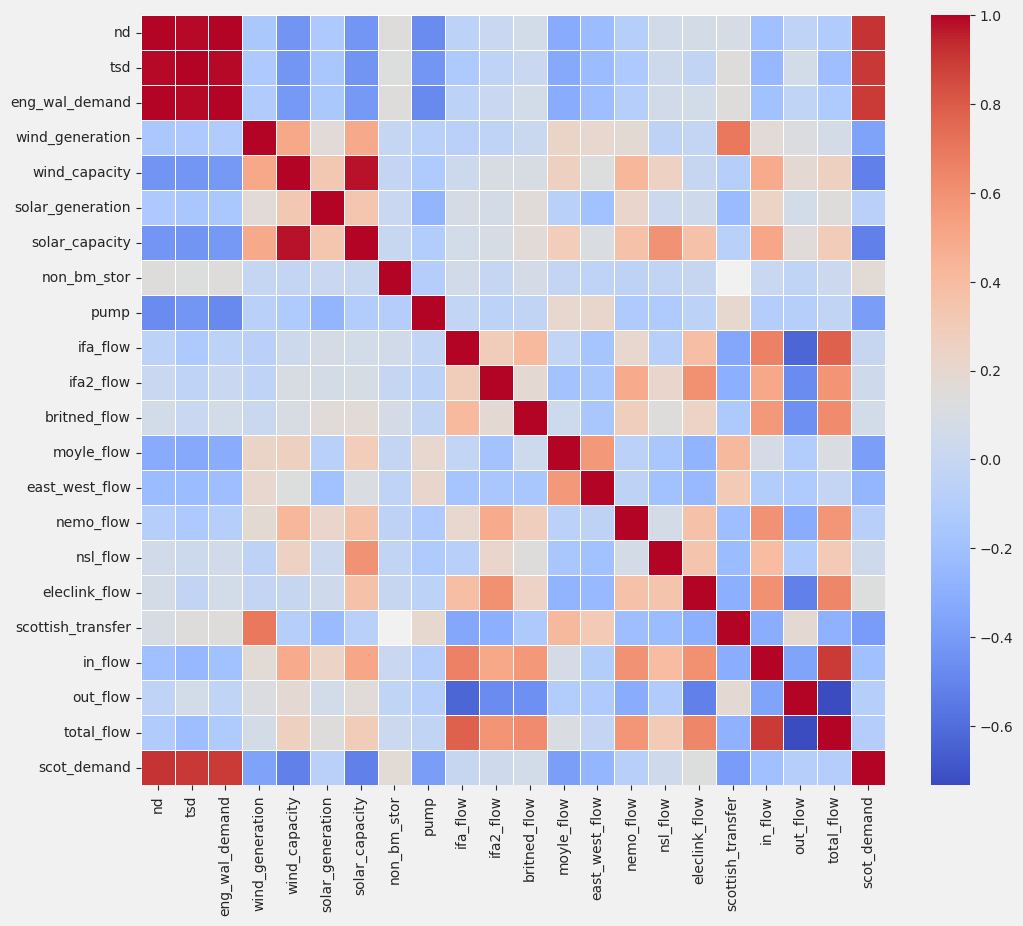

In [26]:
#corrolation heatmap for all non-date numerical cols
plt.figure(figsize=(12, 10))
fig01 = sns.heatmap(dfc[non_dates].corr(), cmap='coolwarm', linewidths=0.5);

In [27]:
# flow distributions (in panels)
# scottish demand so high?
# total flow distros (3 panels)

## Demand for electricity through the day

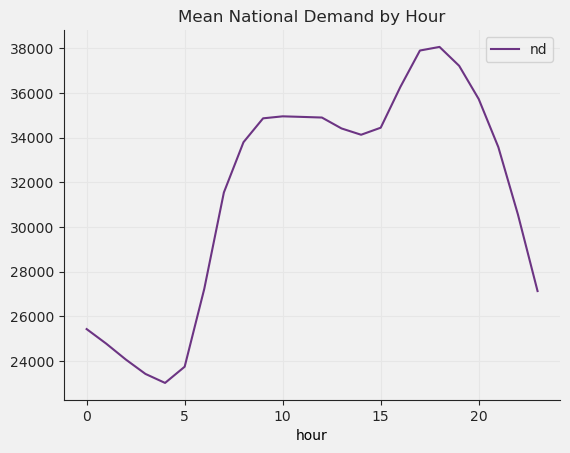

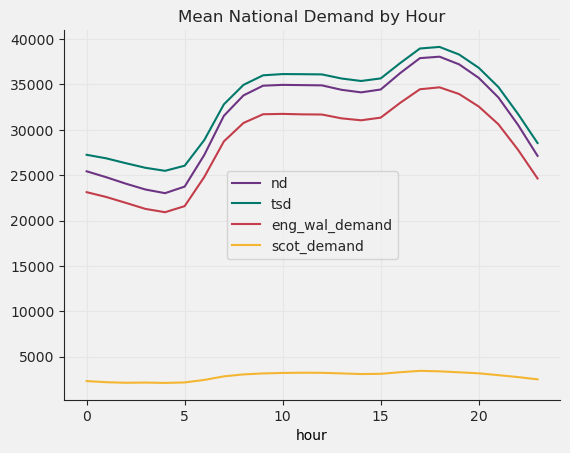

In [28]:
plt.figure()
fig02 = sns.lineplot(dfc.groupby("hour")[["nd"]].mean(), dashes=False)
plt.title("Mean National Demand by Hour")
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/demand_by_hour.png');

plt.figure()
fig03 = sns.lineplot(dfc.groupby("hour")[["nd", "tsd", "eng_wal_demand", "scot_demand"]].mean(), dashes=False)
plt.title("Mean National Demand by Hour")
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/demand_by_hour.png');

Demand is lowest around 4am, when most of the country is asleep. It stays relatively flat between 9am-3pm, which is when most people are in school/work. It hits its peak around 5-6pm, when most people come home and use electronic devices, appliances, heating and lighting, and tails off as the evening gets later and people go to bed.

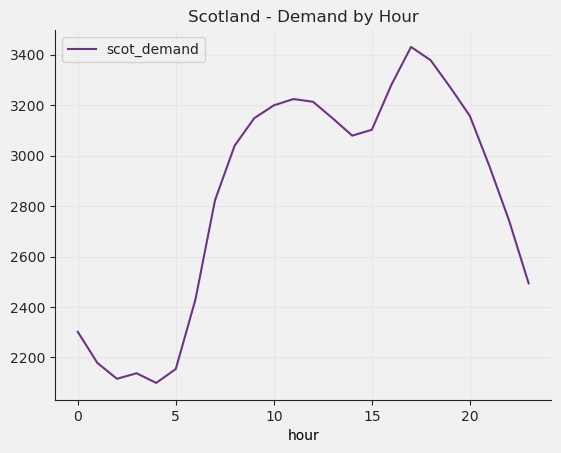

In [29]:
plt.figure()
fig03 = sns.lineplot(dfc.groupby("hour")[["scot_demand"]].mean())
plt.title("Scotland - Demand by Hour")
plt.grid(True, c="#E6E6E6")

Zooming in on Scotland's demand, which was flattened out in the last figure, we see a similar pattern with a peak in the evening and low points in the very early morning.

C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\2257796903.py:2: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  fig04ax1 = sns.violinplot(data=dfc, hue='6_hr_period', y='nd', palette=pigeon)


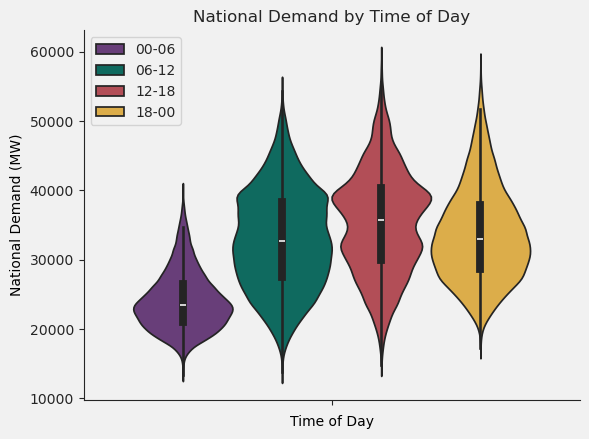

In [30]:
plt.figure()
fig04ax1 = sns.violinplot(data=dfc, hue='6_hr_period', y='nd', palette=pigeon)

plt.title("National Demand by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("National Demand (MW)")
plt.grid(False)
handles, labels = fig04ax1.get_legend_handles_labels()
fig04ax1.legend(handles=handles[:], labels=['00-06', '06-12', '12-18', '18-00'], loc='upper left')
plt.savefig('exports/demand_by_timeperiod_violin.png');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


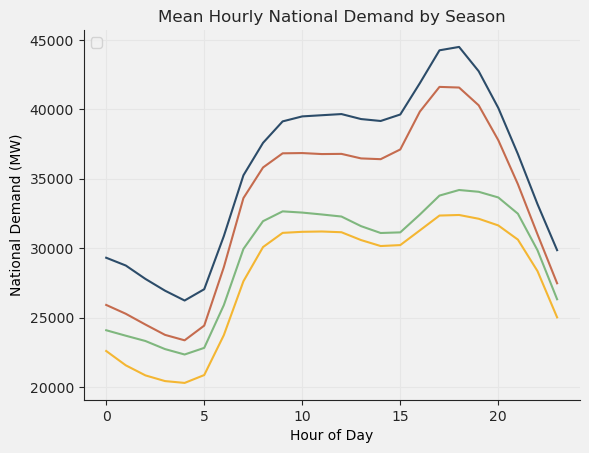

In [31]:
#for each season, a line showing average national demand by hour
plt.figure()
fig05ax1 = sns.lineplot(dfc[dfc.is_summer==1].groupby("hour")['nd'].mean(), color=summercolor)
fig05ax2 = sns.lineplot(dfc[dfc.is_spring==1].groupby("hour")['nd'].mean(), color=springcolor)
fig05ax3 = sns.lineplot(dfc[dfc.is_autumn==1].groupby("hour")['nd'].mean(), color=autumncolor)
fig05ax4 = sns.lineplot(dfc[dfc.is_winter==1].groupby("hour")['nd'].mean(), color=wintercolor)

plt.title("Mean Hourly National Demand by Season")
plt.xlabel("Hour of Day")
plt.ylabel("National Demand (MW)")
plt.grid(True, c="#E6E6E6")
handles, labels = fig05ax1.get_legend_handles_labels()
fig05ax1.legend(handles=handles[:], labels=['winter','autumn','spring','summer'], loc='upper left')
plt.savefig('exports/seasonal_demand_by_hour.png');

Hourly demand follows the same trends regardless of season - with high points in the evening and low points in early morning, but we can see a marked difference between electricity usage in the seasons, with <b><font color=#2C4C69>winter</b> being the month with highest demand, then <b><font color=#autumn> autumn </b>, then <b><font color=#7FB77E>spring</b>, and <b><font color=#F4B632>summer</b> with the lowest. 

Notably, the lines for <b><font color=#2C4C69>winter</b> and <b><font color=#autumn> autumn </b> are close together, with a gap during the day between those and <b><font color=#7FB77E>spring</b> and <b><font color=#F4B632>summer</b>, which are also close together.

## Demand for electricity through the year

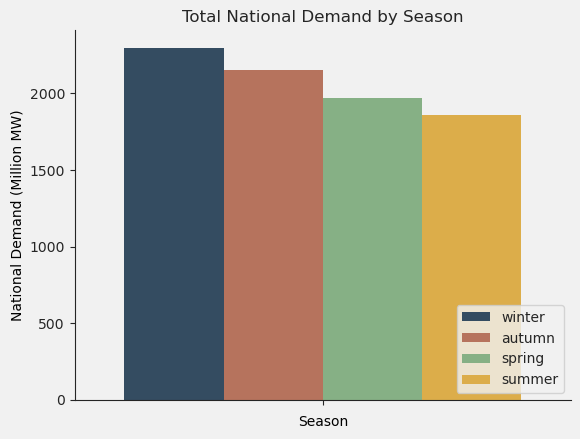

In [32]:
#national demand by season
nd_by_season = dfc.groupby("season")["nd"].sum()
nd_by_season = nd_by_season/1000000  #million
nd_by_season = nd_by_season.round(2).reset_index()
nd_by_season = nd_by_season.sort_values(by='nd', ascending=False)

plt.figure()
fig05 = sns.barplot(data=nd_by_season, hue='season', y='nd', palette=[season_palette[3], season_palette[0], season_palette[1], season_palette[2]])
plt.xlabel('Season')
plt.ylabel('National Demand (Million MW)')
plt.title('Total National Demand by Season')
plt.legend(loc='lower right')
plt.savefig('exports/seasonal_demand_total.png');

Overall, National Demand has been higher in the <b><font color=#2C4C69>winter</b> and lower in the <b><font color=#F4B632>summer</b>.

Let's see if that's true every year.

In [33]:
#national demand by year & season
nd_by_season_yr = dfc.groupby(by=["season", "year"])["nd"].sum().reset_index()
nd_by_season_yr = nd_by_season_yr.sort_values(by='year')
nd_by_season_yr = nd_by_season_yr.reset_index().drop(columns='index')
nd_by_season_yr.nd = round(nd_by_season_yr.nd/1000000, 2) #million
nd_by_season_yr.head()

season  year      nd
0  autumn  2009  160.54
1  winter  2009  175.43
2  spring  2009  150.23
3  summer  2009  143.10
4  summer  2010  142.05

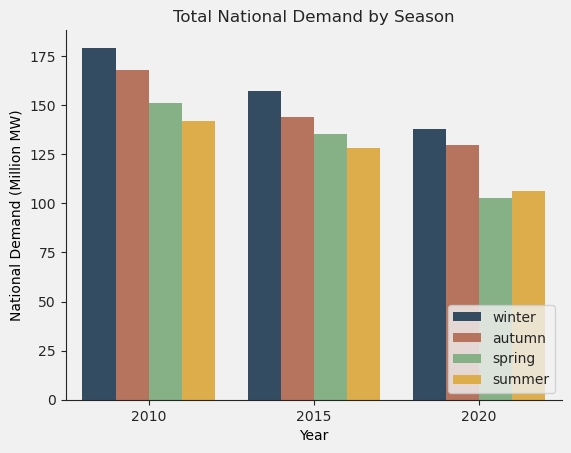

In [34]:
five_yr_filter = (nd_by_season_yr.year == 2010) | (nd_by_season_yr.year == 2015) | (nd_by_season_yr.year == 2020)
nd_by_season_yr_filtered = nd_by_season_yr[five_yr_filter].sort_values(by='nd', ascending=False)

plt.figure()
fig06 = sns.barplot(data=nd_by_season_yr_filtered, x='year', hue='season', y='nd', 
                    palette=[season_palette[3], season_palette[0], season_palette[1], season_palette[2]])
plt.xlabel('Year')
plt.ylabel('National Demand (Million MW)')
plt.title('Total National Demand by Season')
plt.legend(loc='lower right', )
plt.savefig('exports/seasonal_demand_3yr_comparison.png');

We see the same trend where National Demand is higher in the <b><font color=#2C4C69>winter</b> and lower in the <b><font color=#F4B632>summer</b> if we look at specific years. The exception to this is 2020, which has a dip in <b><font color=#7FB77E>spring</b> because of Covid-19.

In [35]:
#relative to one another, are the seasons consistent? Season index with summer as base
season_nd_compar = nd_by_season_yr.pivot(columns='year', index='season')
season_nd_compar_base = season_nd_compar.loc['summer']
season_nd_compar = (season_nd_compar/season_nd_compar_base)*100
season_nd_compar = pd.DataFrame(season_nd_compar.unstack())
season_nd_compar.head(8)

0
   year season            
nd 2009 autumn  112.187282
        spring  104.982530
        summer  100.000000
        winter  122.592593
   2010 autumn  118.049982
        spring  106.342837
        summer  100.000000
        winter  126.216121

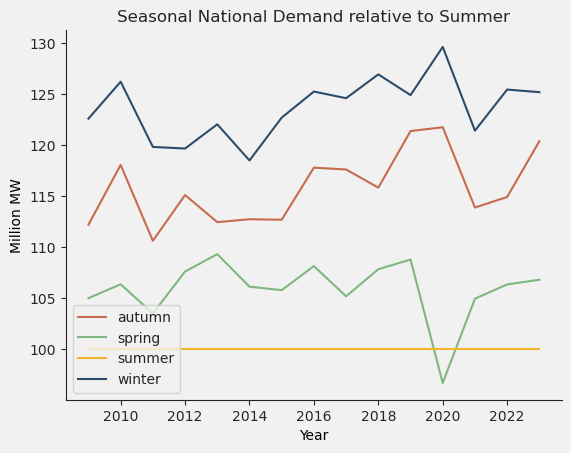

In [36]:
plt.figure()
fig07 = sns.lineplot(data=season_nd_compar, x='year', y=0, hue='season', palette=season_palette)
plt.title('Seasonal National Demand relative to Summer')
plt.ylabel('Million MW')
plt.xlabel('Year')
plt.legend(loc='lower left')
plt.savefig('exports/annual_nd_summer_index.png');

Relative to <b><font color=#F4B632>summer</b>, which is usually the season with the least electricty demand, all seasons were higher each year excpect for <b><font color=#7FB77E>spring</b> 2020, which we've already seen. 

Intrestingly, the highest <b><font color=#2C4C69>winter</b> relative to its <b><font color=#F4B632>summer</b> is also in 2020 - this is likely not related to Covid, as most of <b><font color=#2C4C69>winter</b> 2020 happened before the first Covid-19 lockdown in January-March of 2020. <b><font color=#C56B4E> Autumn </b> 2020, which occurred after the pandemic begun, also demanded a lot of electricity relative to the <b><font color=#F4B632> summer </b> of the same year.

These lines show us that there is some consistency to the electricity demand throughout the year when comparing seasons. While the lines are spiky, they generally do not cross, meaning <b><font color=#2C4C69>winter</b> is always higher than <b><font color=#C56B4E>autumn</b> and so on, with the exception of world-changing events like Covid.

## Demand for electricity year on year

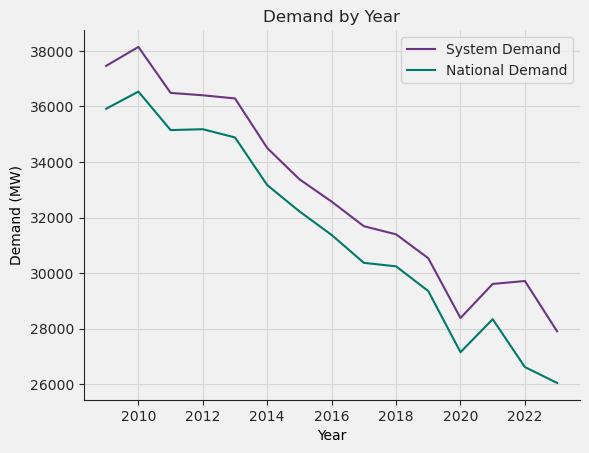

In [37]:
plt.figure()
fig08 = sns.lineplot(dfc.groupby("year")[["tsd","nd"]].mean(), dashes=False)
plt.title("Demand by Year")
plt.xlabel("Year")
plt.ylabel("Demand (MW)")
handles, labels = fig08.get_legend_handles_labels()
fig08.legend(handles=handles[:], labels=['System Demand', 'National Demand'])
plt.grid(True, c="#D6D6D6")
plt.savefig('exports/demand_yoy.png');

National demand has fallen steadily over the years, with its highest point in 2010 and lowest in 2022. 2020 saw an unusual dip in electriciy demand, likely due to the Covid-19 pandemic.

Over the years, appliances and devices have become more efficient, accounting for this gentle, steady decline, despite the population rising on average.

### Let's bring in some population data to understand these trends better

In [38]:
#bring in population data
pop1 = pd.read_excel('data/myebtablesuk20112022.xlsx', 'MYEB4', header=1)
pop1.columns = pop1.columns.str.lower().str.replace(" ", "_")
pop1.laname23.unique()

#only need England, Wales & Scotland:
pop1 = pop1[(pop1.laname23 == 'SCOTLAND') | (pop1.laname23 == 'ENGLAND AND WALES')]
pop1 = pop1.drop(columns = ['ladcode23', 'country'])
pop1.columns = pop1.columns.str.replace("population_", "")
pop1

pop_yr_col_list = []
for i in range(2011, 2023):
    pop_yr_col_list.append(str(i))

#create population dataset with one row per year
pop1 = pop1.groupby(by='laname23')[pop_yr_col_list].sum()
pop1 = pop1.transpose()
pop1.columns = pop1.columns.str.lower().str.replace(" ", "_")
pop1['total_pop'] = pop1['england_and_wales'] + pop1['scotland']
pop1.index = pop1.index.astype(int)
pop1.head(3)

laname23  england_and_wales  scotland  total_pop
2011               56170927   5299900   61470827
2012               56577740   5308500   61886240
2013               56989744   5317300   62307044

In [39]:
#create dataset with annual national demand and interconnector flow
dfc_pop_compar = dfc.copy()
dfc_pop_compar = dfc_pop_compar[(dfc_pop_compar.year != 2009) & (dfc_pop_compar.year != 2010) & (dfc_pop_compar.year != 2023)]
dfc_pop_compar = dfc_pop_compar.groupby(by=['year'])[['nd', 'in_flow', 'out_flow', 'total_flow']].mean()
dfc_pop_compar.head(3)

nd      in_flow    out_flow   total_flow
year                                                    
2011  35149.928311   989.121975  443.903938   545.218037
2012  35181.259506  1559.380920  427.929076  1131.451844
2013  34884.623174  1997.404795  508.858048  1488.546747

In [40]:
#join two above dfs
pop_compar = pop1.merge(dfc_pop_compar, how='inner', left_on=pop1.index, right_on=dfc_pop_compar.index)
pop_compar = pop_compar.rename(columns={'key_0':'year'})
pop_compar = pop_compar.round(2)
pop_compar['total_pop'] = pop_compar['total_pop']/2000
pop_compar.head(3)

year  england_and_wales  scotland   total_pop        nd  in_flow  out_flow  total_flow
0  2011           56170927   5299900  30735.4135  35149.93   989.12    443.90      545.22
1  2012           56577740   5308500  30943.1200  35181.26  1559.38    427.93     1131.45
2  2013           56989744   5317300  31153.5220  34884.62  1997.40    508.86     1488.55

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


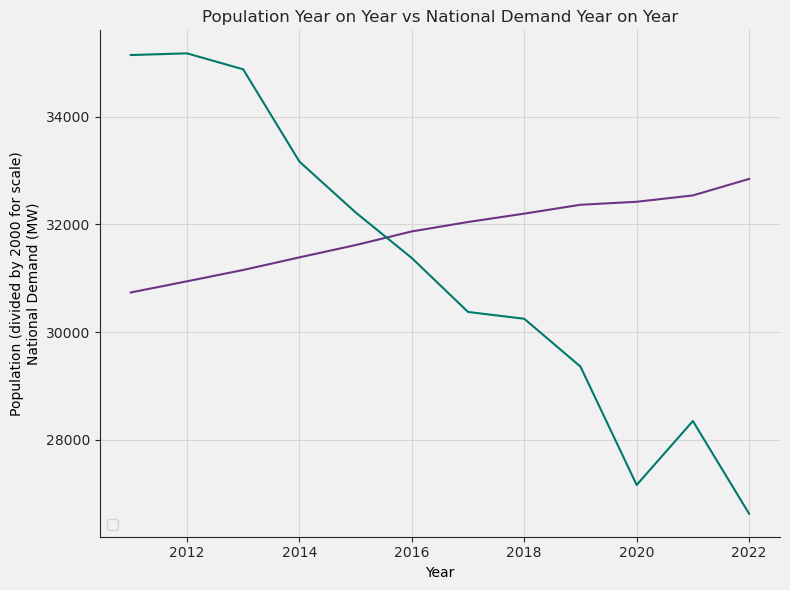

In [41]:
#let's look at national demand relative to population
plt.figure(figsize=(8, 6))
fig09ax1 = sns.lineplot(data=pop_compar, x='year', y='total_pop')
fig09ax2 = sns.lineplot(data=pop_compar, x='year', y='nd')
plt.title('Population Year on Year vs National Demand Year on Year')
plt.xlabel('Year')
plt.ylabel('Population (divided by 2000 for scale)\nNational Demand (MW)')
handles, labels = fig09ax1.get_legend_handles_labels()
fig09ax1.legend(handles=handles[:], labels=['GB Population', 'National Demand'], loc='lower left')
plt.grid(True, c="#D6D6D6")
# plt.legend(loc='lower left', labels=['GB Population', 'Electricty Demand
plt.tight_layout()
plt.savefig('exports/demand_yoy_vs_pop.png');

Despite the increase in population over time, national demand has decreased. Decreased national demand therefore is in spite of a rising population, and not due to a falling one.

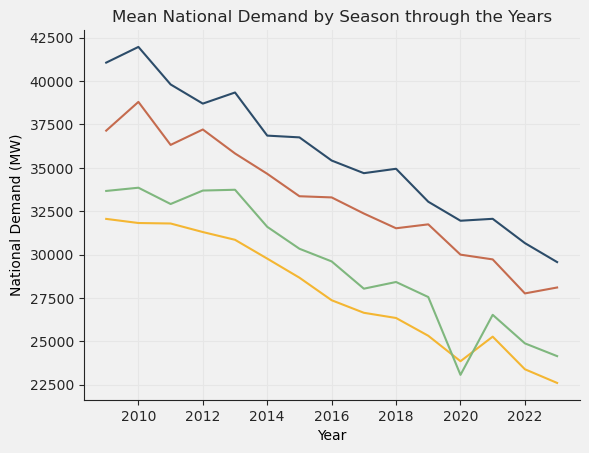

In [42]:
plt.figure()
fig10ax1 = sns.lineplot(dfc[dfc.is_summer==1].groupby("year")['nd'].mean(), color=summercolor)
fig10ax2 = sns.lineplot(dfc[dfc.is_spring==1].groupby("year")['nd'].mean(), color=springcolor)
fig10ax3 = sns.lineplot(dfc[dfc.is_autumn==1].groupby("year")['nd'].mean(), color=autumncolor)
fig10ax4 = sns.lineplot(dfc[dfc.is_winter==1].groupby("year")['nd'].mean(), color=wintercolor)

plt.title("Mean National Demand by Season through the Years")
plt.xlabel("Year")
plt.ylabel("National Demand (MW)")
# plt.legend();
plt.grid(True, c="#E6E6E6")

As above, the national demand has usually fallen year over year, and this is true for each season separately as well. However, in <b><font color=#7FB77E>spring</b> of 2020, electricity demand was unusually low. This dip coincides with the first Covid lockdown across the UK, before all workplaces had found ways to safely keep people in office or working from home. Office buildings were empty, not needing air conditioning, heating, or lighting, and many workers who would go on to work from home were instead furloughed. There is a similar, though less pronounced, dip in <b><font color=#F4B632>summer</b> 2020, likely for similar reasons.

In [43]:
#trying to plot similar to above using Bokeh, so I can make it so you can hover over lines to see which is which
#since the legend gets messed up in seaborn

# data = ColumnDataSource(dfc)
# fig07 = figure(width=500, height=400)
# fig07.line(x=dfc.year, y=dfc.nd)

# show(fig07)

#abandoned this as Bokeh would only show figures in a new tab and not in notebook

In [44]:
dfc.head(1)

date                   dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day   weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
0  2009-01-01  2009-01-01 00:00:00       1  38704  37910           33939         3971               54           1403                 0               0            0    33      2002          0             0        -161               0          0       NaN            NaN   2002.0     161.0      1841.0       2002.0       2002.0      -161                NaN  2009      1    1  Thursday     0       0  00:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1

# Interconnectors

Interconnectors send electricity between countries. The island of Great Britain now has interconnectors with several European countries (France, Belgium, Netherlands, Ireland, Northern Ireland, Norway, and Denmark), with more planned in future. Northern Ireland is included here as it's across the sea, and not part of the NESO. Denmark has been excluded as it wasn't commissioned until 2024. Interconnectors are leveraged to send Electricity out of one location to balance the grid and offload excess, as well as to help other nations with their peak times. By sharing resources in this way, we're able to be more energy efficient as a planet, as excess electricity produced that can't be stored can be used by other nations.

In [45]:
#rerun interconnector columns as that code sits within cleaning section:
interconnectors = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow']
#france interconnectors
france_ics = ['ifa_flow', 'ifa2_flow', 'eleclink_flow']
#interconnectors with France merged into one:
ics_merged_fr = ['france_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow']
#interconnectors without France
ics_no_fr = ['britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow']

### Looking at Interconnector flow distribution

In [46]:
#create df with unpivoted interconnector columns
dfc_ic_values = dfc.melt(id_vars=['dt', 'date', 'period', 'year', 'month', 'day',
                                  '6_hr_period', '4_hr_period', '3_hr_period', 'season'],
                                  value_vars=interconnectors)
dfc_ic_values = dfc_ic_values.rename(columns={'variable':'interconnector', 'value':'ic_flow_mw'})
dfc_ic_values = dfc_ic_values.sort_values(by='interconnector')
dfc_ic_values = dfc_ic_values.fillna(0)
print(dfc_ic_values.shape)
dfc_ic_values.head(3)

(2103552, 12)


dt        date  period  year  month  day  6_hr_period  4_hr_period  3_hr_period  season interconnector  ic_flow_mw
788831  2023-10-29 23:30:00  2023-10-29      48  2023     10   29            4            6            8  autumn   britned_flow       566.0
701174  2019-01-20 19:00:00  2019-01-20      39  2019      1   20            4            5            7  winter   britned_flow      1058.0
701175  2019-01-20 19:30:00  2019-01-20      40  2019      1   20            4            5            7  winter   britned_flow      1059.0

In [47]:
#remove 0 values from ic_flow_mw when it's because IC wasn't yet commissioned
dfc_ic_values.interconnector.unique()
dfc_ic_values_clean = dfc_ic_values[(dfc_ic_values.interconnector=='ifa_flow') | (dfc_ic_values.interconnector=='moyle_flow')]
dfc_ic_values_clean

dfc_ic_values_dirty = dfc_ic_values[(dfc_ic_values.interconnector!='ifa_flow') & (dfc_ic_values.interconnector!='moyle_flow')]
dfc_ic_values_dirty

ics_for_cleaning = list(dfc_ic_values_dirty.interconnector.unique())
ics_for_cleaning

#for each dirty IC, I need to remove the 0s from the top of the data.
#separate out df, sort by dt, find index row of 

def clean_dfc_ic_values(ic):
    a = dfc_ic_values_dirty[dfc_ic_values_dirty.interconnector==ic].sort_values(by='dt').reset_index()
    a = a[a[a.ic_flow_mw > 0].index[0]:]
    return a

cleaned_ic_dfs = [dfc_ic_values_clean,
                  clean_dfc_ic_values(ics_for_cleaning[0]),
                  clean_dfc_ic_values(ics_for_cleaning[1]),
                  clean_dfc_ic_values(ics_for_cleaning[2]),
                  clean_dfc_ic_values(ics_for_cleaning[3]),
                  clean_dfc_ic_values(ics_for_cleaning[4]),
                  clean_dfc_ic_values(ics_for_cleaning[5])]

print(dfc_ic_values_clean.shape)

dfc_ic_values_full_clean = pd.concat(cleaned_ic_dfs, axis=0)
dfc_ic_values_full_clean = dfc_ic_values_full_clean.drop(columns='index')
dfc_ic_values_full_clean.head()

(525888, 12)


dt        date  period  year  month  day  6_hr_period  4_hr_period  3_hr_period  season interconnector  ic_flow_mw
0       2009-01-01 00:00:00  2009-01-01       1  2009      1    1            1            1            1  winter       ifa_flow      2002.0
131472  2016-07-16 19:00:00  2016-07-16      39  2016      7   16            4            5            7  summer       ifa_flow      1991.0
175286  2019-01-20 19:00:00  2019-01-20      39  2019      1   20            4            5            7  winter       ifa_flow      1998.0
175287  2019-01-20 19:30:00  2019-01-20      40  2019      1   20            4            5            7  winter       ifa_flow      1998.0
175288  2019-01-20 20:00:00  2019-01-20      41  2019      1   20            4            6            7  winter       ifa_flow      1999.0

['ifa_flow' 'moyle_flow' 'britned_flow' 'east_west_flow' 'eleclink_flow'
 'ifa2_flow' 'nemo_flow' 'nsl_flow']


C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\2438969182.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.boxplot(data=dfc_ic_values_full_clean, x='interconnector', y='ic_flow_mw', palette=pigeon[0:4])
C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\2438969182.py:8: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax1 = sns.boxplot(data=dfc_ic_values_full_clean, x='interconnector', y='ic_flow_mw', palette=pigeon[0:4])


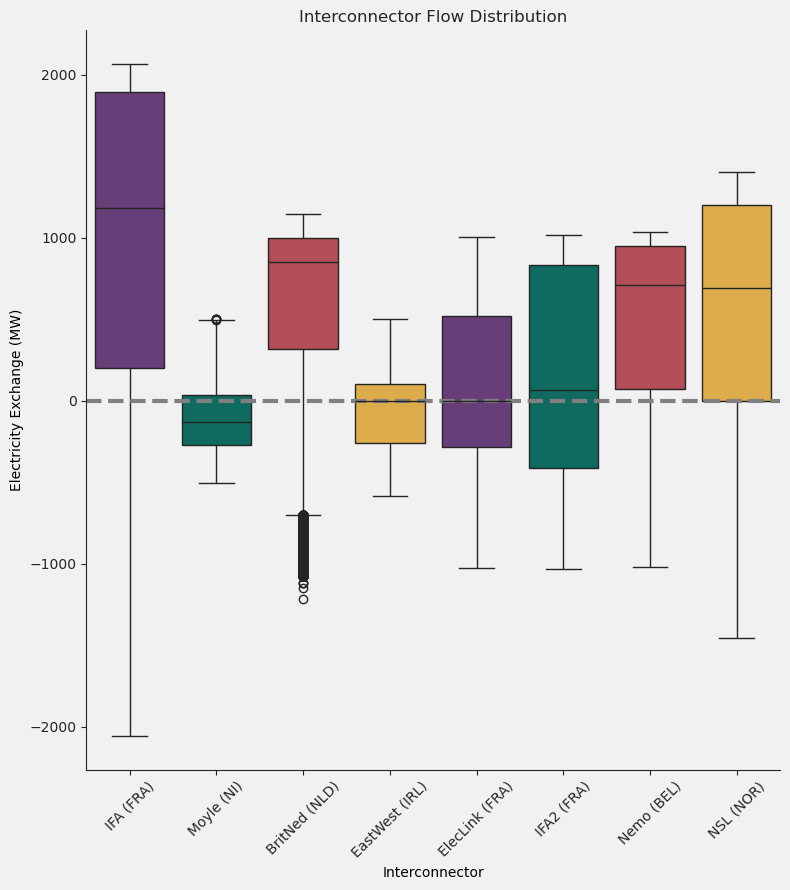

In [48]:
#create box plot showing interconnector flow distribution

dfc_ic_values_full_clean
interconnectors = ['ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow']
print(dfc_ic_values_full_clean.interconnector.unique())

plt.figure(figsize=(8, 9))
ax1 = sns.boxplot(data=dfc_ic_values_full_clean, x='interconnector', y='ic_flow_mw', palette=pigeon[0:4])
plt.ylabel('Electricity Exchange (MW)')
plt.xlabel('Interconnector')
plt.xticks(ticks=dfc_ic_values_full_clean.interconnector.unique(), 
           labels=['IFA (FRA)', 'Moyle (NI)', 'BritNed (NLD)', 'EastWest (IRL)', 'ElecLink (FRA)', 'IFA2 (FRA)', 'Nemo (BEL)', 'NSL (NOR)'], 
           rotation=45)
plt.title('Interconnector Flow Distribution')
plt.axhline(y=0, c='grey', ls='--', lw=3)
plt.tight_layout()
plt.savefig('exports/ic_flow_distro.png');

In [49]:
dfc_ic_values_full_clean.groupby('interconnector')['ic_flow_mw'].mean()

interconnector
britned_flow      607.815403
east_west_flow    -45.819390
eleclink_flow      37.257048
ifa2_flow         131.311951
ifa_flow          910.305894
moyle_flow       -115.555609
nemo_flow         477.938904
nsl_flow          572.377687
Name: ic_flow_mw, dtype: float64

In [50]:
dfc_ic_max = dfc_ic_values_full_clean.groupby('interconnector')['ic_flow_mw'].max()
dfc_ic_max = dfc_ic_max.reset_index()
dfc_ic_max = pd.DataFrame(dfc_ic_max)
type(dfc_ic_max)
dfc_ic_max
# list(dfc_ic_max.interconnector)

interconnector  ic_flow_mw
0    britned_flow      1143.0
1  east_west_flow       504.0
2   eleclink_flow      1002.0
3       ifa2_flow      1016.0
4        ifa_flow      2066.0
5      moyle_flow       499.0
6       nemo_flow      1033.0
7        nsl_flow      1401.0

C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\1901830691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dfc_ic_max, x='interconnector', y='ic_flow_mw',palette=pigeon[0:4])
C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\1901830691.py:2: UserWarning: 
The palette list has fewer values (4) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=dfc_ic_max, x='interconnector', y='ic_flow_mw',palette=pigeon[0:4])


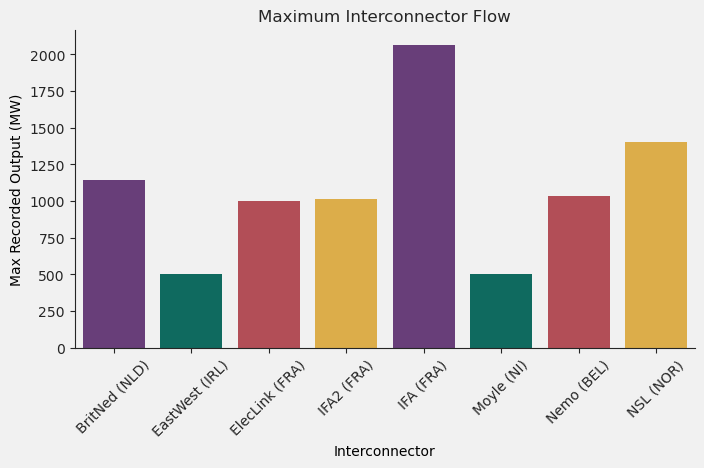

In [51]:
plt.figure(figsize=(8,6))
sns.barplot(data=dfc_ic_max, x='interconnector', y='ic_flow_mw',palette=pigeon[0:4])
plt.ylabel('Max Recorded Output (MW)')
plt.xlabel('Interconnector')
plt.xticks(ticks=list(dfc_ic_max.interconnector), 
           labels=['BritNed (NLD)','EastWest (IRL)', 'ElecLink (FRA)', 'IFA2 (FRA)', 'IFA (FRA)', 'Moyle (NI)', 'Nemo (BEL)', 'NSL (NOR)'], 
           rotation=45)
plt.title('Maximum Interconnector Flow')
plt.gcf().subplots_adjust(bottom=0.35)
plt.savefig('exports/ic_flow_max.png');

#### How much electricity is sent/received through our interconnectors through the day?

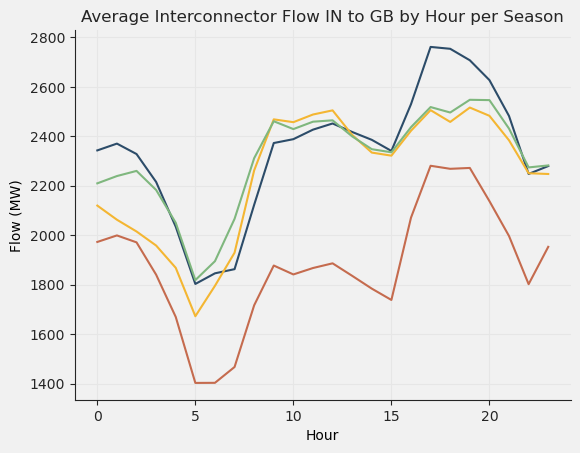

In [52]:
plt.figure()
fig11ax1 = sns.lineplot(dfc[dfc.is_winter==1].groupby("hour")['in_flow'].mean(), dashes=False, color=wintercolor)
fig11ax2 = sns.lineplot(dfc[dfc.is_summer==1].groupby("hour")['in_flow'].mean(), dashes=False, color=summercolor)
fig11ax3 = sns.lineplot(dfc[dfc.is_autumn==1].groupby("hour")['in_flow'].mean(), dashes=False, color=autumncolor)
fig11ax4 = sns.lineplot(dfc[dfc.is_spring==1].groupby("hour")['in_flow'].mean(), dashes=False, color=springcolor)

plt.title("Average Interconnector Flow IN to GB by Hour per Season")
plt.xlabel("Hour")
plt.ylabel("Flow (MW)")
#plt.legend(labels=['Winter', 'Summer', 'Autumn', 'Spring'])
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/av_seasonal_ic_in_by_hr.png');

GB receives the least Electricity in <b><font color=#C56B4E> autumn </b> and more during <b><font color=#2C4C69>winter</b>, <b><font color=#F4B632>summer</b>, or <b><font color=#7FB77E>spring</b>.

GB receives the least Electricty around <b>5am</b>, regardless of season, a relatively steady amount during the working hours of <b>9am</b> to <b>3pm</b>, and the most in the afteroon, around <b>5-6pm</b>.

The ultimate peak of this data is in <b><font color=#2C4C69>winter</b> at <b>5pm</b>, which coincides with when people are leaving work and arriving home, and when people are most likely to be at home neading heating and light.

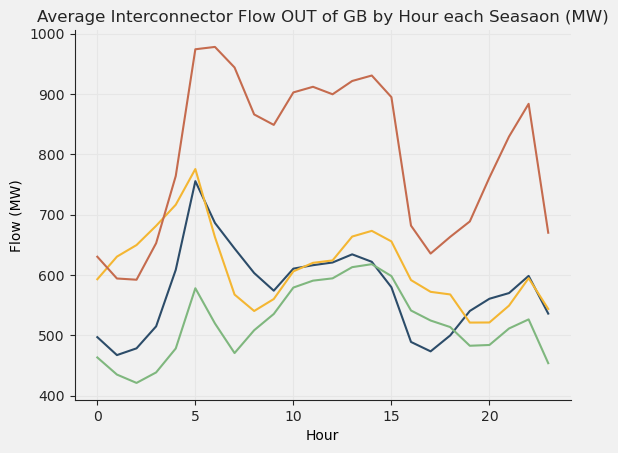

In [53]:
plt.figure()
fig12ax2 = sns.lineplot((dfc[dfc.is_winter==1].groupby("hour")['out_flow'].mean()), dashes=False, color=wintercolor)
fig12ax2 = sns.lineplot((dfc[dfc.is_summer==1].groupby("hour")['out_flow'].mean()), dashes=False, color=summercolor)
fig12ax2 = sns.lineplot((dfc[dfc.is_spring==1].groupby("hour")['out_flow'].mean()), dashes=False, color=springcolor)
fig12ax2 = sns.lineplot((dfc[dfc.is_autumn==1].groupby("hour")['out_flow'].mean()), dashes=False, color=autumncolor)

plt.title("Average Interconnector Flow OUT of GB by Hour each Seasaon (MW)")
plt.xlabel("Hour")
plt.ylabel("Flow (MW)")
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/av_seasonal_ic_out_by_hr.png');

Comparing this plot to the above, we can see the figures are roughly mirrored, which makes sense, as we can only send electricity in one direction at a time per interconnector.

GB sends out the most Electricity in <b><font color=#C56B4E> autumn </b> and less during <b><font color=#2C4C69>winter</b>, <b><font color=#F4B632>summer</b>, or <b><font color=#7FB77E>spring</b>. This time, however, there's a clearer gap between <b><font color=#7FB77E>spring</b> and the other seasons, so we can see that during <b><font color=#7FB77E>spring</b>, especially at <b>night</b>, we're sending less electricity to other countries.

GB sends the most Electricty around <b>5am</b>, regardless of season. Most Britains are still asleep at this time, but those in Europe are starting their days. 

We see a relatively steady line during the working hours of <b>9am</b> and <b>3pm</b>, as most people are in work or school, and the least in the afteroon, around <b>5-6pm</b> as people return home and use their appliances and electronics.

The lowest point within general waking hours is around <b>5pm</b> in <b><font color=#2C4C69>winter</b>, which is when many people are arriving home from work/school and will be most in need of heating and light on top of using electronics and appliances.

This pattern is interesting as it would seem to benefit Great Britain based on our schedules, but the countries we exchange electricity with have a time difference of no more than 1 hour, so other countries are employing other methods or leaning on other interconnector connections to balance their electricity throughout the day.



In [54]:
#total flow in & out inc and not_inc Northern Ireland (NI):
dfc.head()

dfc_ni = dfc.groupby('date')[['moyle_flow', 'in_flow', 'out_flow']].sum()
dfc_ni['in_flow_excl_moyle'] = np.where(dfc_ni['moyle_flow']>0, dfc_ni.in_flow - dfc_ni.moyle_flow, dfc_ni.in_flow)
dfc_ni['out_flow_excl_moyle'] = np.where(dfc_ni['moyle_flow']<0, dfc_ni.out_flow + dfc_ni.moyle_flow, dfc_ni.in_flow)
dfc_ni = dfc_ni.reset_index()

dfc_ni['group'] = 0
dfc_ni_sums = dfc_ni.groupby('group')[['in_flow', 'out_flow', 'in_flow_excl_moyle', 'out_flow_excl_moyle']].sum()
dfc_ni_sums = dfc_ni_sums/1000000
dfc_ni_sums = dfc_ni_sums.rename(columns = {'in_flow':'IN, inc N. Ire', 'out_flow':'OUT, inc N. Ire',
                              'in_flow_excl_moyle':'IN, excl N. Ire', 'out_flow_excl_moyle':'OUT, excl N. Ire'})

C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\1956262608.py:2: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=dfc_ni_sums, palette=pigeon[0:2])


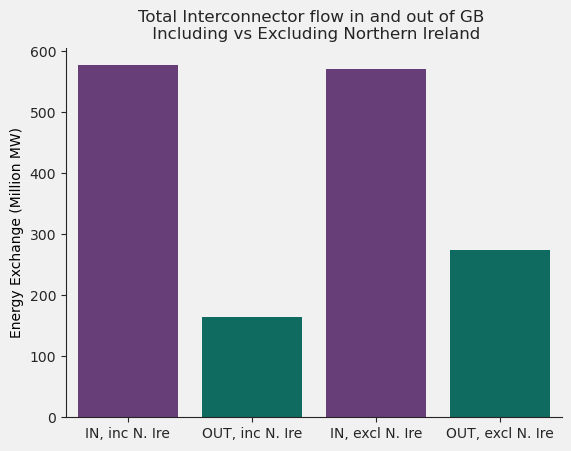

In [55]:
#plot barchart
sns.barplot(data=dfc_ni_sums, palette=pigeon[0:2])
plt.title('Total Interconnector flow in and out of GB \n Including vs Excluding Northern Ireland')
plt.ylabel('Energy Exchange (Million MW)')
plt.savefig('exports/ic_flow_totals_consider_ni.png');

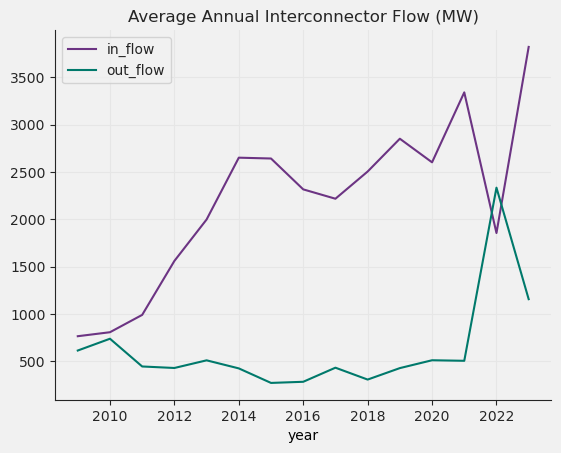

In [56]:
plt.figure()
fig13 = sns.lineplot(dfc.groupby("year")[["in_flow", "out_flow"]].mean(), dashes=False)
plt.title("Average Annual Interconnector Flow (MW)")
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/av_annual_ic_flow.png');

In [57]:
#reminder for formatting markdowns
season_colours

{'winter': '#2C4C69',
 'spring': '#7FB77E',
 'summer': '#F4B632',
 'autumn': '#C56B4E'}

We received much more electricity than we sent out throughout most of the recorded time - this makes sense as GB is one location, and we're looking at our exchange with 6 separate countries (including NI as separate from GB and Ireland) across 9 interconnectors.

In 2022, where the lines cross, GB sent more electricity out than it recieved, but the pattern diverges again in 2023.

We're not yet sure why this is, so let's look at each country separately.

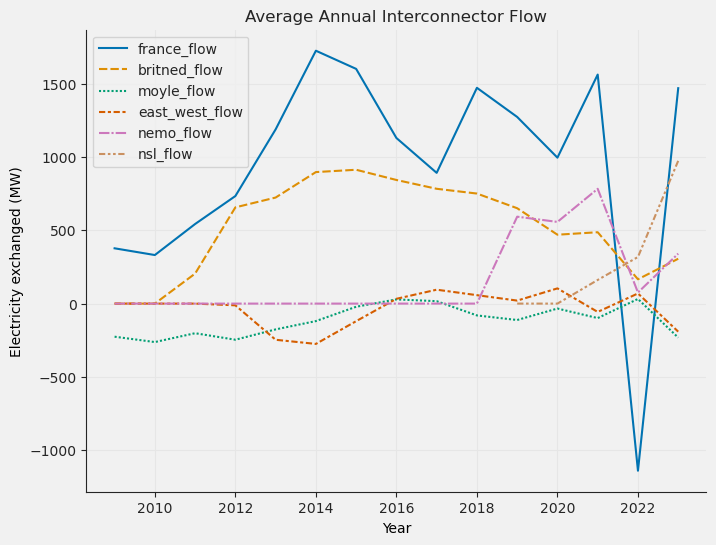

In [58]:
#All Interconnectors
plt.figure(figsize=(8, 6))
fig14 = sns.lineplot(dfc.groupby("year")[ics_merged_fr].mean(), palette='colorblind')
plt.title("Average Annual Interconnector Flow")
plt.grid(True, c="#E6E6E6")
plt.ylabel('Electricity exchanged (MW)')
plt.xlabel('Year')
plt.savefig('exports/av_annual_ic_flow_by_country.png');

<b><font color=#0173b2>france_flow</b> accounts for our highest and lowest points, which is logical since it represents the sum of 3 different interconnectors. <b><font color=#0173b2>France</b> is currently the only country we have multiple connections with. In 2022, we sent more electricity to <b><font color=#0173b2>France</b> than any other country. This accounts for the dip in the graph above in 2022, as our exchanges with other countries were all positive, but relatively low in comparison.

NB: where the list is at 0, the interconnector was not yet commissioned. E.g. the <b><font color=#cc78bc>Nemo</b> interconnector with <b><font color=#cc78bc>Belgium</b> was commissioned for use in 2019.

In [59]:
#French connectors
fr_ic_compar = dfc.groupby("year")[["ifa_flow", "ifa2_flow", "eleclink_flow"]].sum()
fr_ic_compar = fr_ic_compar.fillna(0)
fr_ic_compar = fr_ic_compar.stack().reset_index()
fr_ic_compar = fr_ic_compar.rename(columns={'level_1':'interconnector',0:'flow'})
fr_ic_compar['flow'] = fr_ic_compar['flow']/1000000
fr_ic_compar.head()

year interconnector      flow
0  2009       ifa_flow  6.605764
1  2009      ifa2_flow  0.000000
2  2009  eleclink_flow  0.000000
3  2010       ifa_flow  5.801842
4  2010      ifa2_flow  0.000000

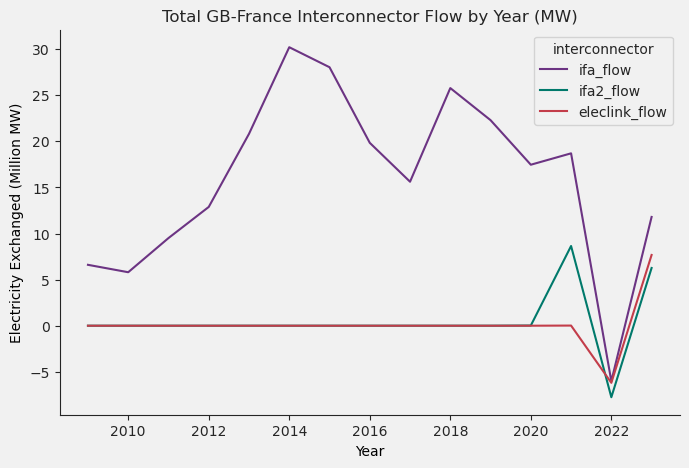

In [60]:
plt.figure(figsize=(8,5))
fig15 = sns.lineplot(data = fr_ic_compar, x='year', y='flow', hue='interconnector')
plt.title("Total GB-France Interconnector Flow by Year (MW)")
plt.xlabel('Year')
plt.ylabel('Electricity Exchanged (Million MW)')
plt.grid(False)
plt.savefig('exports/av_annual_ic_flow_france.png');

<b><font color=#884a9d>IFA1</b> (Interconnexion France-Angleterre) was the first interconnector built between GB and another country. <b><font color=#01987b>IFA2</b> started running in 2021, and <b><font color=#ce445d>ElecLink</b>, which travels along the channel tunnel, in 2022.

Each year except 2022, France has sent Great Britain more electricity than it has received from us. In 2022, all 3 interconnectors were below 0, meaning they all sent more electricity from GB to France than the other way around, so no one interconnector is responsible for the dip in the two graphs above.

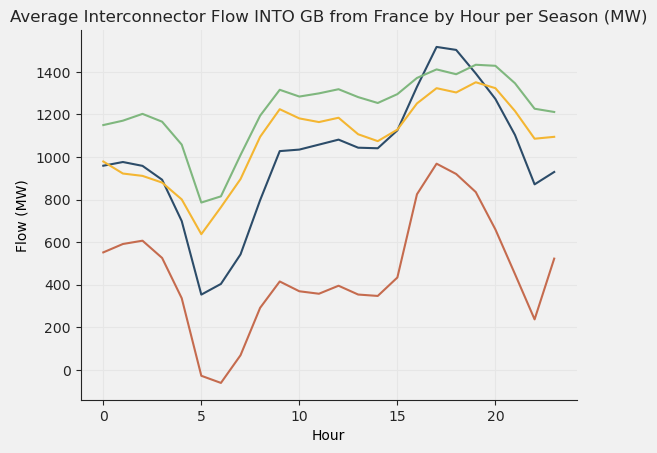

In [61]:
plt.figure()
fig16ax1 = sns.lineplot(dfc[dfc.is_winter==1].groupby("hour")['france_flow'].mean(), dashes=False, color=wintercolor)
fig16ax2 = sns.lineplot(dfc[dfc.is_summer==1].groupby("hour")['france_flow'].mean(), dashes=False, color=summercolor)
fig16ax3 = sns.lineplot(dfc[dfc.is_autumn==1].groupby("hour")['france_flow'].mean(), dashes=False, color=autumncolor)
fig16ax4 = sns.lineplot(dfc[dfc.is_spring==1].groupby("hour")['france_flow'].mean(), dashes=False, color=springcolor)

plt.title("Average Interconnector Flow INTO GB from France by Hour per Season (MW)")
plt.xlabel("Hour")
plt.ylabel("Flow (MW)")
#plt.legend(labels=['Winter', 'Summer', 'Autumn', 'Spring'])
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/av_france_flow_in_by_hr_season.png');

France is sending GB the least electricity in <b><font color=#C56B4E> autumn</b>, and the most in <b><font color=#7FB77E>spring</b>  generally. However the times when France is sending GB the most electricity tend to be afternoons in <b><font color=#2C4C69>winter</b>.


 > <b><font color=#2C4C69>winter</b>
 
 > <b><font color=#C56B4E> autumn</b>
 
 > <b><font color=#7FB77E>spring</b>
 
 ><b><font color=#F4B632>summer</b>

## Let's make maps

In [62]:
dfc_geog = dfc.copy()
dfc_geog = dfc_geog.drop(columns=['wind_generation','wind_capacity','solar_generation','solar_capacity',
                                  'non_bm_stor','pump','scottish_transfer'])

geog_ics_dict = {'britned_flow':'netherlands', 'nemo_flow':'belgium', 'nsl_flow':'norway',
                 'moyle_flow':'northern_ireland', 'east_west_flow':'republic_of_ireland', 'france_flow':'france'}

dfc_geog = dfc_geog.rename(columns=geog_ics_dict)
geog_ics = list(geog_ics_dict.values())

In [63]:
#create dictionary for country totals 
ic_country_keys = []
ic_country_abs_values = []
#create dictionary for interconnector in flows per country
ic_country_in_values = []
#create dictionary for interconnector out flows per country
ic_country_out_values = []

for i in geog_ics:
    #append keys
    ic_country_keys.append(i)

    flow_series = dfc_geog[i]
    #create absolute totals and append to totals values list
    ic_country_abs_values.append(abs(flow_series.sum()))
    #add to in flow values list
    ic_country_in_values.append(flow_series[flow_series>0].sum())
    #add to out flow values list
    ic_country_out_values.append(abs(flow_series[flow_series<0].sum()))

#create df
ic_flows_by_country = pd.DataFrame({'name':ic_country_keys, 'total_flow':ic_country_abs_values,
                                   'in_flow': ic_country_in_values, 'out_flow': ic_country_out_values})
ic_flows_by_country

name   total_flow      in_flow    out_flow
0          netherlands  137597248.0  150443009.0  12845761.0
1              belgium   41179216.0   49815842.0   8636626.0
2               norway   25456873.0   29897420.0   4440547.0
3     northern_ireland   30384654.0   12609581.0  42994235.0
4  republic_of_ireland    9157156.0   17701215.0  26858371.0
5               france  248023432.0  315593408.0  67569976.0

<Axes: ylabel='name'>

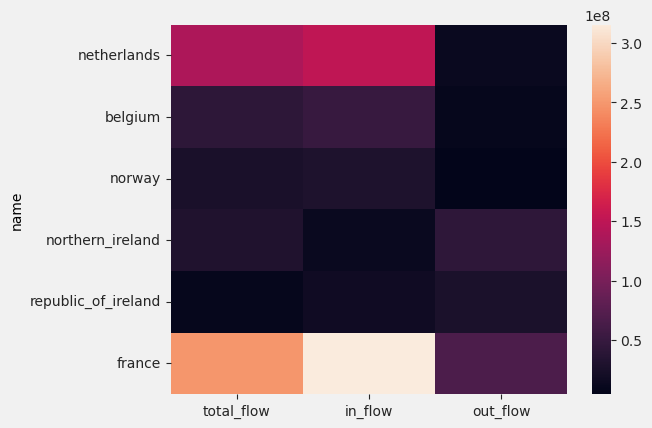

In [64]:
sns.heatmap(ic_flows_by_country.set_index(keys='name'))

In [65]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [66]:
pip install geodatasets

Note: you may need to restart the kernel to use updated packages.


In [67]:
#bring in europe geography to plot with geopandas
import geopandas
import geodatasets
europe = geopandas.read_file("data/europe.geojson")
europe.head()

C:\Users\knigh\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


FID FIPS ISO2 ISO3   UN                    NAME   AREA  POP2005  REGION  SUBREGION     LON     LAT                                           geometry
0  0.0   AJ   AZ  AZE   31              Azerbaijan   8260  8352021     142        145  47.395  40.430  MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...
1  0.0   AL   AL  ALB    8                 Albania   2740  3153731     150         39  20.068  41.143  POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...
2  0.0   AM   AM  ARM   51                 Armenia   2820  3017661     142        145  44.563  40.534  MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...
3  0.0   BK   BA  BIH   70  Bosnia and Herzegovina   5120  3915238     150         39  17.786  44.169  POLYGON ((17.64984 42.88908, 17.57853 42.94382...
4  0.0   BU   BG  BGR  100                Bulgaria  11063  7744591     150        151  25.231  42.761  POLYGON ((27.87917 42.8411, 27.895 42.8025, 27...

In [68]:
#bring in UK country data to split off NI from GB.
northernireland = geopandas.read_file("data/northern-ireland_1319.geojson")
england = geopandas.read_file("data/england-uk_1321.geojson")
wales = geopandas.read_file("data/wales-uk_1320.geojson")
scotland = geopandas.read_file("data/scotland-uk_1322.geojson")
scotland
scotlandtest = scotland.iloc[8]

In [69]:
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

In [70]:
ni_mp_list = northernireland.geometry.astype(str).to_list()

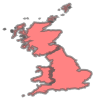

In [71]:
#merge polygons in northern ireland into multipolygon
ni_polygons = wkt.loads(ni_mp_list)
ni_multipoly = MultiPolygon([wkt.loads(i) for i in ni_mp_list])

#merge scotland england wales to make GB
gb_island = pd.concat([england,wales,scotland],ignore_index=True)
gb_island_mp_list  = gb_island.geometry.astype(str).to_list()
gb_polygons = wkt.loads(gb_island_mp_list)
gb_multipoly = MultiPolygon([wkt.loads(i) for i in gb_island_mp_list])
gb_multipoly

In [72]:
#create dictionary with NI & GB multipoly to add to europe df
gb_ni_dict = {'name':['Northern Ireland','Great Britain'], 'geometry': [ni_multipoly,gb_multipoly]}
gb_df = pd.DataFrame(data=gb_ni_dict) #fun fact: GBDF are the notes on the lines in treble clef!
gb_df

name                                           geometry
0  Northern Ireland  MULTIPOLYGON (((-7.234497 55.068146, -7.272949...
1     Great Britain  MULTIPOLYGON (((-2.087402 55.792017, -2.086029...

<Axes: >

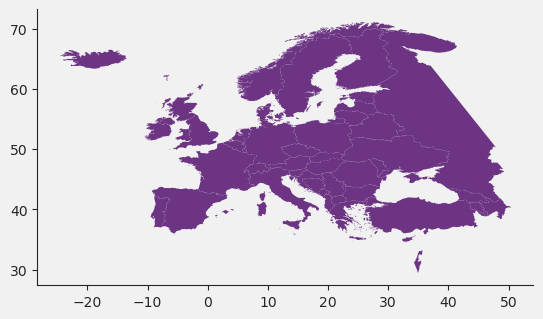

In [73]:
#adjusts europe df to remove cols and replace UK with GB & NI
europe_gb = europe[europe.NAME != 'United Kingdom']
europe_gb = europe_gb[['NAME','geometry']]
europe_gb.columns = europe_gb.columns.str.lower()

#merge europe and gb
europe_gb = pd.concat([europe_gb,gb_df], ignore_index=True)
europe_gb.plot()

In [74]:
europe_gb.head()

name                                           geometry
0              Azerbaijan  MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...
1                 Albania  POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...
2                 Armenia  MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...
3  Bosnia and Herzegovina  POLYGON ((17.64984 42.88908, 17.57853 42.94382...
4                Bulgaria  POLYGON ((27.87917 42.8411, 27.895 42.8025, 27...

In [75]:
#align country names 
ic_flows_by_country.name = ic_flows_by_country.name.apply(lambda x: x.replace("_", " ").title().replace('Republic Of ',""))
ic_flows_by_country

name   total_flow      in_flow    out_flow
0       Netherlands  137597248.0  150443009.0  12845761.0
1           Belgium   41179216.0   49815842.0   8636626.0
2            Norway   25456873.0   29897420.0   4440547.0
3  Northern Ireland   30384654.0   12609581.0  42994235.0
4           Ireland    9157156.0   17701215.0  26858371.0
5            France  248023432.0  315593408.0  67569976.0

In [76]:
#merge europe_gb with ic_flows_by_country
europe_gb = europe_gb.merge(ic_flows_by_country, how='outer', on='name')
#million megawatts
europe_gb[['total_flow', 'in_flow', 'out_flow']] = europe_gb[['total_flow', 'in_flow', 'out_flow']]  /1000000
europe_gb.head(8)

name                                           geometry  total_flow    in_flow  out_flow
0                 Albania  POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...         NaN        NaN       NaN
1                 Andorra  POLYGON ((1.78172 42.56996, 1.77472 42.57111, ...         NaN        NaN       NaN
2                 Armenia  MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...         NaN        NaN       NaN
3                 Austria  POLYGON ((13.83361 48.7736, 13.85806 48.77055,...         NaN        NaN       NaN
4              Azerbaijan  MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...         NaN        NaN       NaN
5                 Belarus  POLYGON ((26.61321 55.67484, 26.62 55.6836, 26...         NaN        NaN       NaN
6                 Belgium  POLYGON ((4.30238 51.26318, 4.30968 51.26203, ...   41.179216  49.815842  8.636626
7  Bosnia and Herzegovina  POLYGON ((17.64984 42.88908, 17.57853 42.94382...         NaN        NaN       NaN

In [77]:
europe_gb.sample(5)

name                                           geometry  total_flow  in_flow  out_flow
25                   Israel  MULTIPOLYGON (((35.25972 31.78722, 35.25444 31...         NaN      NaN       NaN
28            Liechtenstein  POLYGON ((9.53357 47.27454, 9.56639 47.24389, ...         NaN      NaN       NaN
45                 Slovenia  POLYGON ((13.71866 46.52661, 13.77611 46.51833...         NaN      NaN       NaN
33               Montenegro  POLYGON ((18.45556 42.56583, 18.46389 42.56944...         NaN      NaN       NaN
21  Holy See (Vatican City)  POLYGON ((12.44509 41.90312, 12.45165 41.90799...         NaN      NaN       NaN

In [78]:
#add means per interconnector to europe_gb
ic_means = dfc_ic_values_full_clean.groupby('interconnector')['ic_flow_mw'].mean().reset_index()
ic_means['name'] = ic_means['interconnector'].map(geog_ics_dict)
ic_means = ic_means.fillna('France')
ic_means['name'] = ic_means['name'].apply(lambda x: x.replace("_", " ").title().replace('Republic Of ',""))
country_means = ic_means.groupby('name')['ic_flow_mw'].mean().reset_index()
country_means

europe_gb_means = europe_gb.copy()
europe_gb_means = europe_gb_means.merge(country_means, how='outer', on='name')

In [79]:
europe_gb_means.head(1)

name                                           geometry  total_flow  in_flow  out_flow  ic_flow_mw
0  Albania  POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...         NaN      NaN       NaN         NaN

<Figure size 640x480 with 0 Axes>

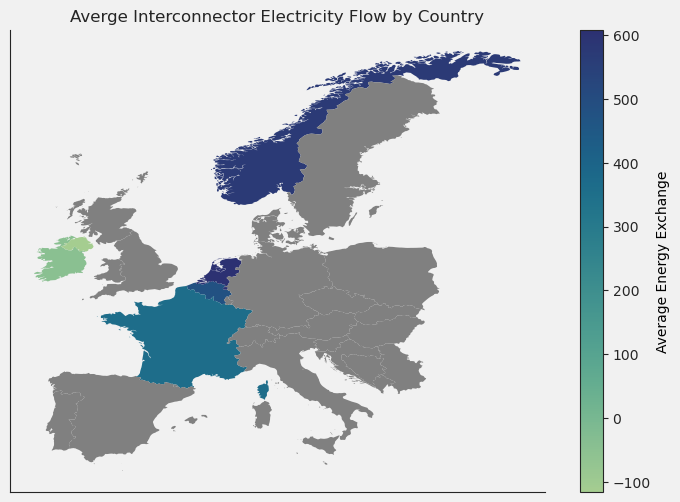

In [80]:
#mean flow by country
plt.figure()
fig45 = europe_gb_means.cx[-12:19, :].plot(column='ic_flow_mw',
                             cmap='crest', 
                             legend=True,
                            legend_kwds={"label": "Average Energy Exchange", "orientation": "vertical"},
                             figsize=(9, 6), missing_kwds={"color": "grey"},)
plt.title("Averge Interconnector Electricity Flow by Country")
plt.xticks(ticks=None, labels=None)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
plt.savefig('exports/choro_mean.png');

<Figure size 640x480 with 0 Axes>

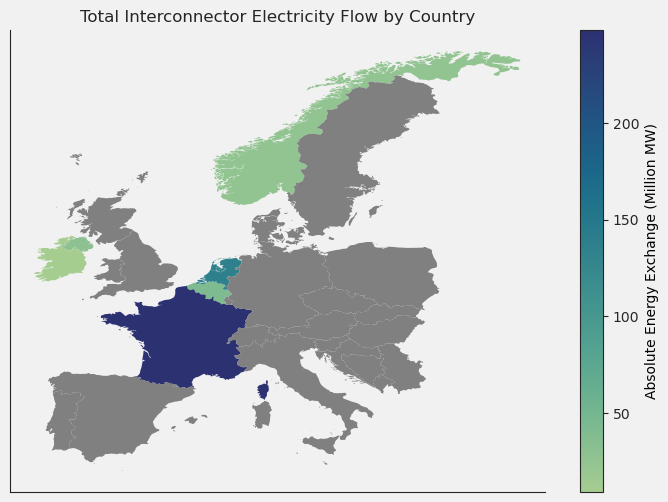

In [81]:
#most flow by country
plt.figure()
fig44 = europe_gb.cx[-12:19, :].plot(column='total_flow',
                             cmap='crest', 
                             legend=True,
                            legend_kwds={"label": "Absolute Energy Exchange (Million MW)", "orientation": "vertical"},
                             figsize=(9, 6), missing_kwds={"color": "grey"},)
plt.title("Total Interconnector Electricity Flow by Country")
plt.xticks(ticks=None, labels=None)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
plt.savefig('exports/choro_total.png');

# Renewable Energy

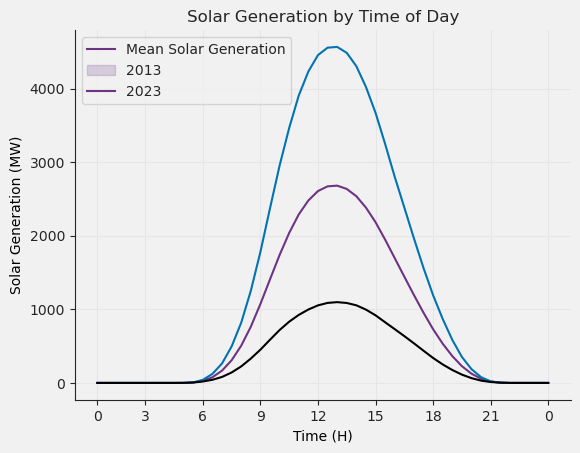

In [82]:
plt.figure()
fig20ax1 = sns.lineplot(dfc.groupby("period")[["solar_generation"]].mean())
fig20ax2 = sns.lineplot(dfc[dfc['year']==2023].groupby("period")[["solar_generation"]].mean(), palette='colorblind')
fig20ax2 = sns.lineplot(dfc[dfc['year']==2013].groupby("period")[["solar_generation"]].mean(), palette=['black'])
plt.title("Solar Generation by Time of Day")
plt.xlabel("Time (H)")
plt.ylabel("Solar Generation (MW)")
plt.xticks(ticks=[1, 6, 12, 18, 24, 30, 36, 42, 48], labels=[0, 3, 6, 9, 12, 15, 18, 21, 0])
plt.legend(["Mean Solar Generation", "2013", "2023"])
plt.grid(True, c="#E6E6E6");

Unsurprisingly, solar power generation is at its highest around midday, although the middle is closer to 1pm, and has a normal distribution as light levels rise and fall through the course of the day.

The <b><font color=#884a9d>purple</b> line represents the mean solar energy generation <b><font color=#884a9d>throughout the data</b>, and the <b><font color=#187fb8>blue</b> line shows average solar power generation in <b><font color=#187fb8>2023</b>. The **black** line for contrast shows solar power gen in 2013, 10 years earlier.

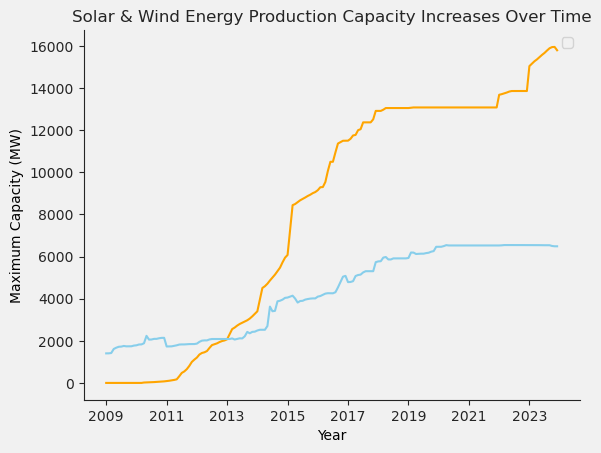

In [83]:
plt.figure()
fig21ax1 = sns.lineplot(dfc.groupby("year_month")["solar_capacity"].agg(["mean"]), palette=["orange"])
fig21ax2 = sns.lineplot(dfc.groupby("year_month")["wind_capacity"].agg(["mean"]), palette=["skyblue"])
plt.title("Solar & Wind Energy Production Capacity Increases Over Time")
plt.xlabel("Year")
plt.xticks(ticks=['2009-01', '2011-01','2013-01',
                  '2015-01', '2017-01',
                  '2019-01', '2021-01', '2023-01'], 
           labels=[2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023])
plt.ylabel("Maximum Capacity (MW)")
plt.legend([])
plt.savefig('exports/wind_solar_cap_overtime.png');

<b><font color='skyblue'>wind</b>
<b><font color='orange'>solar</b>

C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\275907162.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  fig22 = sns.lineplot(dfc.groupby("year")[["solar_generation", "solar_capacity"]].mean(), palette=["orange"])
C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\275907162.py:4: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  fig23 = sns.lineplot(dfc.groupby("year")[["wind_generation", "wind_capacity"]].mean(), palette=["skyblue"])


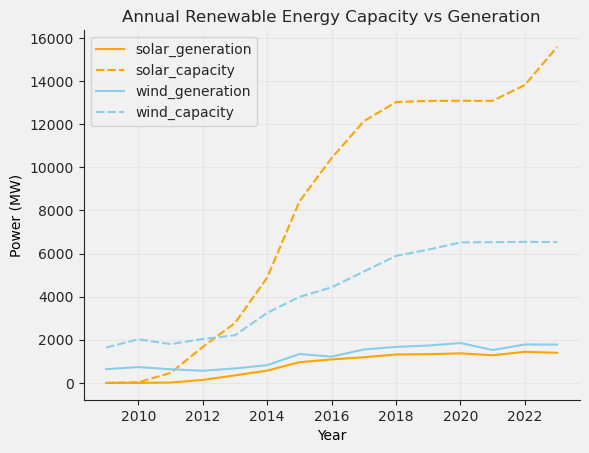

In [84]:
#Other Europe Interconnectors
plt.figure()
fig22 = sns.lineplot(dfc.groupby("year")[["solar_generation", "solar_capacity"]].mean(), palette=["orange"])
fig23 = sns.lineplot(dfc.groupby("year")[["wind_generation", "wind_capacity"]].mean(), palette=["skyblue"])
plt.title("Annual Renewable Energy Capacity vs Generation")
plt.grid(True, c="#E6E6E6")
plt.ylabel('Power (MW)')
plt.xlabel('Year')
plt.savefig('exports/wind_solar_cap_vs_gen_overtime.png');

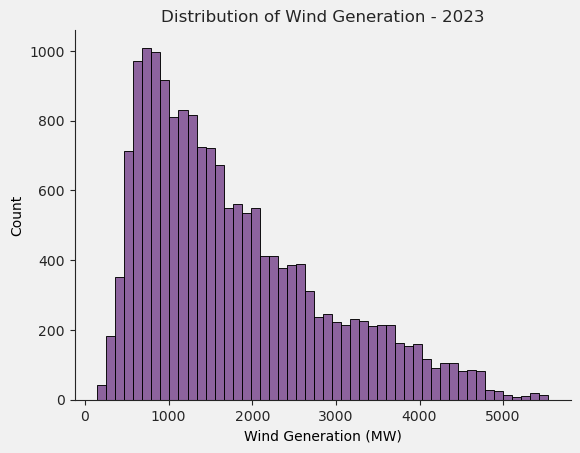

In [119]:
plt.figure()
fig24 = sns.histplot(data=dfc[dfc.year==2023], x="wind_generation", bins=50)
plt.title("Distribution of Wind Generation - 2023")
plt.xlabel("Wind Generation (MW)")
plt.savefig('exports/wind_gen_distro');

Wind distribution is positively skewed.

In [124]:
#checking my time periods for next plot
display(dfc[(dfc.period >= 17) & (dfc.period <= 41)].head(1))
display(dfc[(dfc.period >= 17) & (dfc.period <= 41)].tail(1))

date                   dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day   weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
16  2009-01-01  2009-01-01 08:00:00      17  31094  29007           26030         2977               75           1403                 0               0            0  1487      1689          0             0          15               0          0       NaN            NaN   1704.0       0.0      1704.0       1689.0       1689.0        15                NaN  2009      1    1  Thursday     8       0  08:00:00    2009-01        0          0          0          0          1  winter            2            3            3       1

date                   dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
262936  2023-10-29  2023-10-29 20:00:00      41  30220  28661           26601         2060             2589           6488                 0           15954            0     7      1506        991          1002        -452            -495       1019      -5.0          997.0   5515.0     952.0      4563.0       3494.0       3494.0      -947             3651.0  2023     10   29  Sunday    20       0  20:00:00    2023-10        1          0          0          1          0  autumn            4            6            7       0

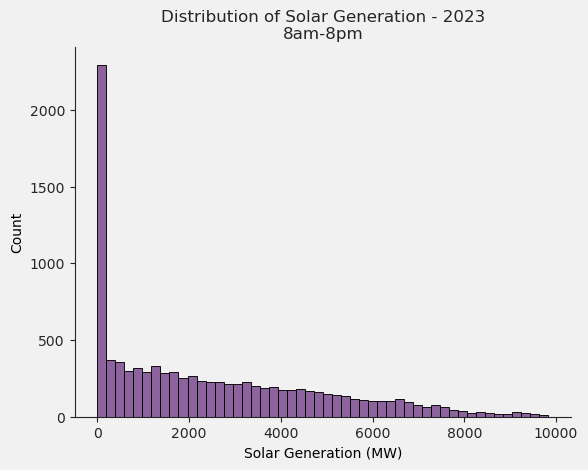

In [128]:
plt.figure()
# fig25 = sns.histplot(data=dfc[dfc.year==2023], x="solar_generation", bins=50);
fig25 = sns.histplot(data=dfc[(dfc.year == 2023) & (dfc.period >= 15) & (dfc.period <= 41)], x="solar_generation", bins=50);
plt.title("Distribution of Solar Generation - 2023\n8am-8pm")
plt.xlabel("Solar Generation (MW)")
plt.savefig('exports/solar_gen_distro');

In [87]:
#is there always solar generation in summer? 
#filter for 1pm solar generation in july since we had capacity - there are no 0s, meaning we always get some gen at least in summer at peak time
dfc[(dfc['solar_generation'] == 0) & (dfc['month']==7) & (dfc['solar_capacity'] != 0) & (dfc['period'] == 27)]

Empty DataFrame
Columns: [date, dt, period, tsd, nd, eng_wal_demand, scot_demand, wind_generation, wind_capacity, solar_generation, solar_capacity, non_bm_stor, pump, ifa_flow, ifa2_flow, britned_flow, moyle_flow, east_west_flow, nemo_flow, nsl_flow, eleclink_flow, in_flow, out_flow, total_flow, france_flow, non_fr_flow, ioi_flow, scottish_transfer, year, month, day, weekday, hour, minute, time, year_month, weekend, is_spring, is_summer, is_autumn, is_winter, season, 6_hr_period, 4_hr_period, 3_hr_period, is_hol]
Index: []

# Misc

<Figure size 640x480 with 0 Axes>

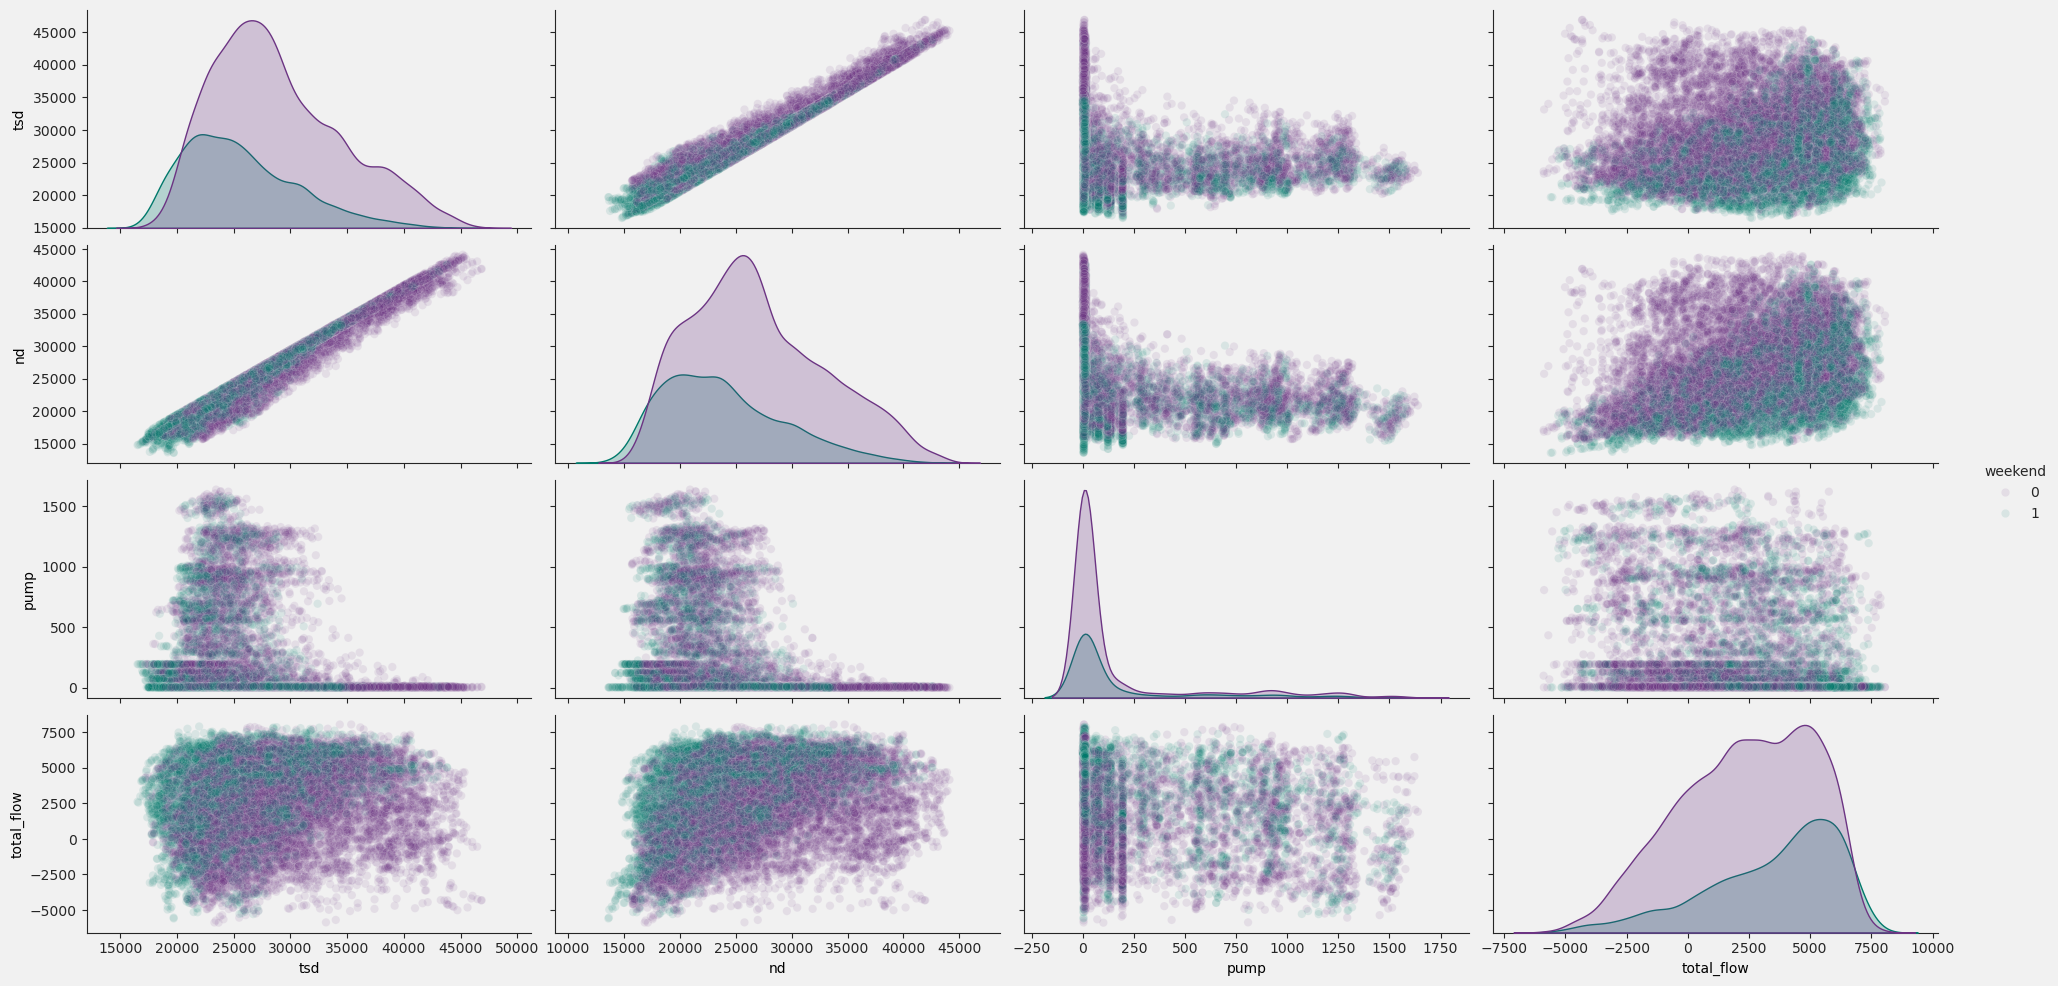

In [88]:
# zero iterations of this pairplot have felt useful but OK hun
plt.figure()
pair_plot_cols = ['date', 'tsd', 'nd', 'pump', 'total_flow', 'weekend']

dfc_pair = dfc[pair_plot_cols]
alpha=0.1

fig26 = sns.pairplot(dfc_pair[dfc['year']==2023], hue='weekend', aspect=2, plot_kws=dict(alpha=alpha))

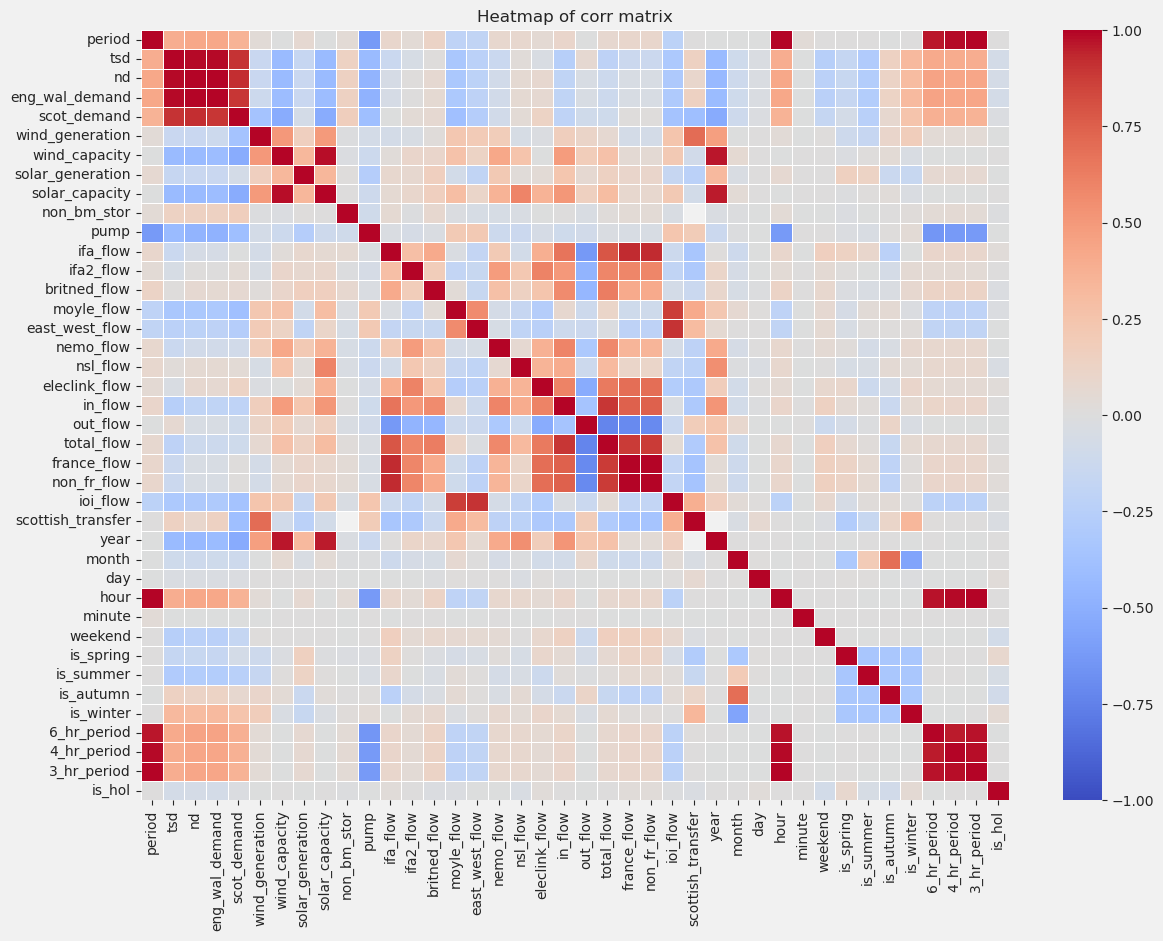

In [89]:
plt.figure(figsize=(14, 10))
fig27 = sns.heatmap(dfc.corr(numeric_only=True),cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Heatmap of corr matrix')

plt.show()

In [90]:
corr_mat = dfc.corr(numeric_only=True)
corr_mat[(corr_mat > 0.6) | (corr_mat < -0.6)]

period       tsd        nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor      pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow   in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer      year     month  day      hour  minute  weekend  is_spring  is_summer  is_autumn  is_winter  6_hr_period  4_hr_period  3_hr_period  is_hol
period             1.000000       NaN       NaN             NaN          NaN              NaN            NaN               NaN             NaN          NaN -0.617352       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN                NaN       NaN       NaN  NaN  0.999348     NaN      NaN        NaN        NaN        NaN        NaN     0.968456     0.986227     0.992372     NaN
tsd                     NaN  1.000000  0.990948        0.990306     0.904527              NaN            NaN               NaN             NaN          NaN       NaN       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN                NaN       NaN       NaN  NaN       NaN     NaN      NaN        NaN        NaN        NaN        NaN          NaN          NaN          NaN     NaN
nd                      NaN  0.990948  1.000000        0.998943     0.916351              NaN            NaN               NaN             NaN          NaN       NaN       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN                NaN       NaN       NaN  NaN       NaN     NaN      NaN        NaN        NaN        NaN        NaN          NaN          NaN          NaN     NaN
eng_wal_demand          NaN  0.990306  0.998943        1.000000     0.896976              NaN            NaN               NaN             NaN          NaN       NaN       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN                NaN       NaN       NaN  NaN       NaN     NaN      NaN        NaN        NaN        NaN        NaN          NaN          NaN          NaN     NaN
scot_demand             NaN  0.904527  0.916351        0.896976     1.000000              NaN            NaN               NaN             NaN          NaN       NaN       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN                NaN       NaN       NaN  NaN       NaN     NaN      NaN        NaN        NaN        NaN        NaN          NaN          NaN          NaN     NaN
wind_generation         NaN       NaN       NaN             NaN          NaN         1.000000            NaN               NaN             NaN          NaN       NaN       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN           0.695566       NaN       NaN  NaN       NaN     NaN      NaN        NaN        NaN        NaN        NaN          NaN          NaN          NaN     NaN
wind_capacity           NaN       NaN       NaN             NaN          NaN              NaN       1.000000               NaN        0.978300          NaN       NaN       NaN        NaN           NaN         NaN             NaN        NaN       NaN            NaN       NaN       NaN         NaN          NaN          NaN       NaN                NaN  0.963419       NaN  NaN       NaN     NaN      NaN        NaN        NaN        NaN        NaN          NaN          NaN          NaN     NaN
solar_generation        NaN       NaN       NaN             N

In [91]:
dfc.head(1)

date                   dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day   weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
0  2009-01-01  2009-01-01 00:00:00       1  38704  37910           33939         3971               54           1403                 0               0            0    33      2002          0             0        -161               0          0       NaN            NaN   2002.0     161.0      1841.0       2002.0       2002.0      -161                NaN  2009      1    1  Thursday     0       0  00:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1

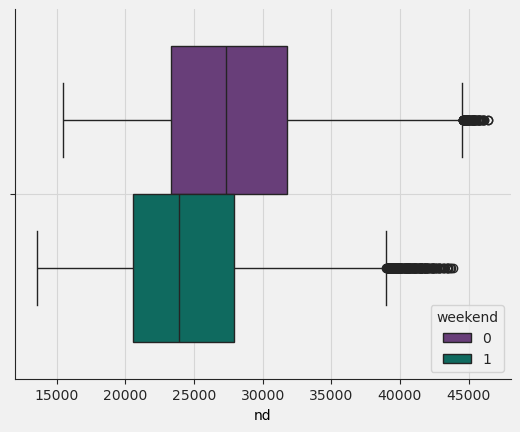

In [92]:
plt.figure()
fig28 = sns.boxplot(dfc[(dfc["year"]>2020) & (dfc["year"]<=2023)], x="nd", hue="weekend")
plt.grid({"axis":"x"}, c="#D6D6D6");

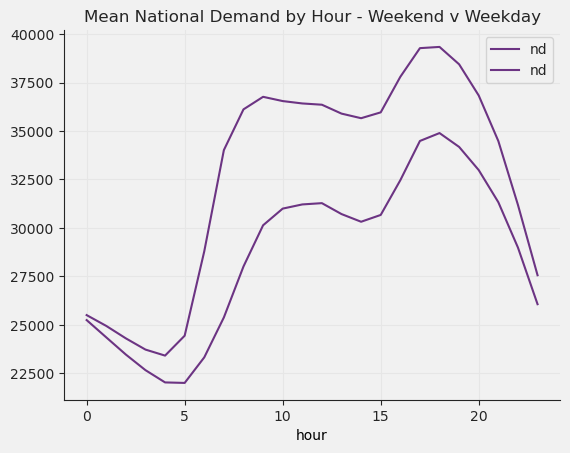

In [93]:
plt.figure()
fig29ax1 = sns.lineplot(dfc[dfc.weekend==1].groupby("hour")[["nd"]].mean(), dashes=False)
fig29ax2 = sns.lineplot(dfc[dfc.weekend==0].groupby("hour")[["nd"]].mean(), dashes=False)
plt.title("Mean National Demand by Hour - Weekend v Weekday")
plt.grid(True, c="#E6E6E6")
plt.savefig('exports/wknd_v_wkdy_demand_by_hour.png');

In [94]:
dfc[dfc.weekend==1]['nd'].mean()

28632.748536611325

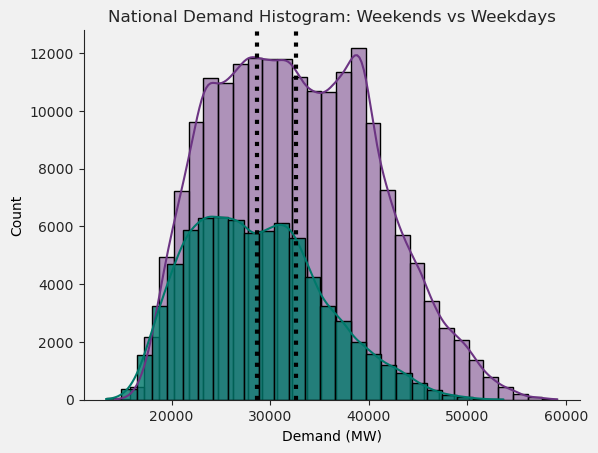

In [95]:
#create a histogram showing distribution on weekdays vs weekends

plt.figure()
sns.histplot(data=dfc[dfc.weekend==0], x='nd', bins=30, kde=True)
sns.histplot(data=dfc[dfc.weekend==1], x='nd', bins=26, kde=True, alpha=0.8)
plt.xlabel('Demand (MW)')
plt.title('National Demand Histogram: Weekends vs Weekdays')
plt.axvline(x = dfc[dfc.weekend==1]['nd'].mean(), lw=3, ls= ':', c='k')
plt.axvline(x = dfc[dfc.weekend==0]['nd'].mean(), lw=3, ls= ':', c='k')
plt.savefig('exports/wknd_v_wkdy_nd_hist.png');

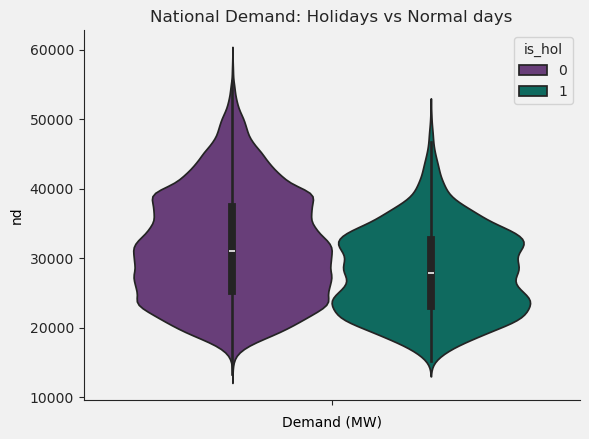

In [96]:
plt.figure()
sns.violinplot(data=dfc, y='nd', hue='is_hol')
plt.xlabel('Demand (MW)')
plt.title('National Demand: Holidays vs Normal days')
plt.savefig('exports/hol_v_non_nd_hist.png');

In [97]:
#create a violin plot showing weekend distro per season

#create a histogram showing distribution on weekdays vs weekends

In [98]:
dfc_dec = dfc[dfc.month==12]
dfc_dec = dfc_dec[['nd', 'date', 'period', 'dt', 'year', 'month', 'day', '6_hr_period', '4_hr_period', 'weekend', 'is_hol']]

dec_wknd_map_dict = {0:'Weekday', 1:'Weekend'}
dec_hol_map_dict = {0:'Non-Holiday', 1:'Holiday'}

dfc_dec['weekend2'] = dfc_dec.weekend.map(dec_wknd_map_dict)
dfc_dec['hol2'] = dfc_dec.is_hol.map(dec_hol_map_dict)
dfc_dec['wknd_hol'] = dfc_dec['weekend2'] + ' ' + dfc_dec['hol2']

dfc_dec_6hr = dfc_dec.groupby(['4_hr_period', 'year', 'wknd_hol'])[['nd']].mean().reset_index()
dfc_dec_6hr

dfc_dec_6hr_sort_key = ['Weekday Non-Holiday','Weekend Non-Holiday','Weekday Holiday','Weekend Holiday']

dfc_dec_6hr = dfc_dec_6hr.sort_values(by ='wknd_hol', key=lambda column: column.map(lambda e: dfc_dec_6hr_sort_key.index(e)))

C:\Users\knigh\AppData\Local\Temp\ipykernel_18660\3374828072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig30 = sns.swarmplot(data=dfc_dec_6hr, x='wknd_hol', y='nd', palette=pigeon[0:4])


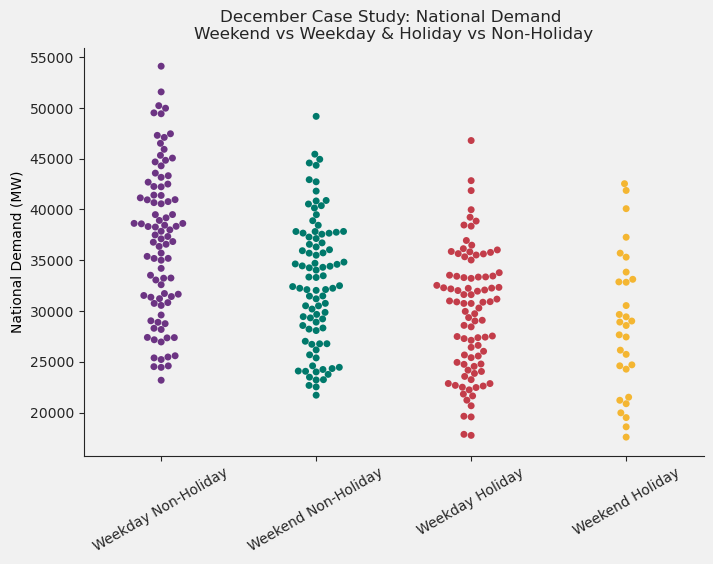

In [99]:
plt.figure(figsize=(8, 6))
fig30 = sns.swarmplot(data=dfc_dec_6hr, x='wknd_hol', y='nd', palette=pigeon[0:4])
plt.xticks(rotation=30)
plt.title('December Case Study: National Demand \nWeekend vs Weekday & Holiday vs Non-Holiday')
plt.ylabel('National Demand (MW)')
plt.xlabel("")
plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('exports/december_case_study.png');

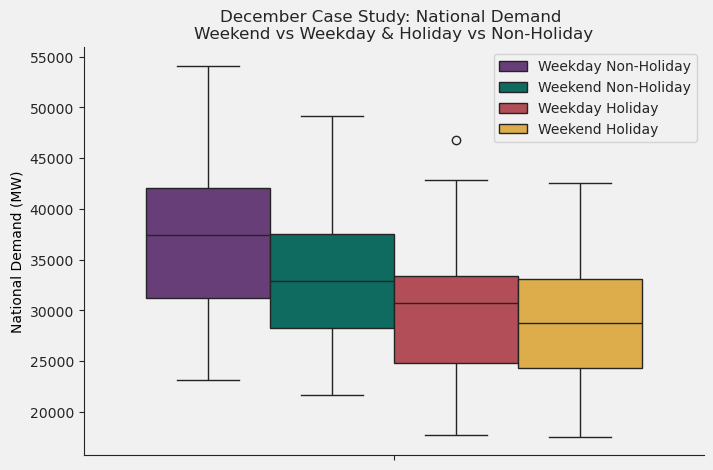

In [100]:
plt.figure(figsize=(8, 6))
fig30 = sns.boxplot(data=dfc_dec_6hr, hue='wknd_hol', y='nd', palette=pigeon[0:4])
plt.xticks(rotation=30)
plt.title('December Case Study: National Demand \nWeekend vs Weekday & Holiday vs Non-Holiday')
plt.ylabel('National Demand (MW)')
plt.xlabel("")
plt.gcf().subplots_adjust(bottom=0.20)
plt.legend(title='')
plt.savefig('exports/december_case_study_box.png');

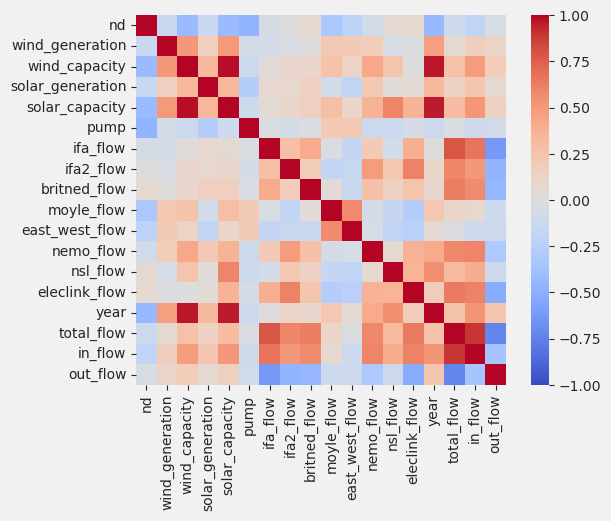

In [101]:
dfc.columns

corr_cols1 = ['nd', 'wind_generation', 
              'wind_capacity', 'solar_generation', 'solar_capacity', 'pump', 
              'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 
              'nemo_flow', 'nsl_flow', 'eleclink_flow', 'year', 'total_flow', 'in_flow', 'out_flow']

corr_cols2 = ['nd', 'wind_capacity', 'solar_capacity', 'wind_generation', 'solar_generation', 
              'pump', 'total_flow', 'year']

plt.figure()
fig29 = sns.heatmap(dfc[corr_cols1].corr(), cmap="coolwarm", center=0, vmin=-1, square=True)

In [102]:
dfc[dfc.year==2023]['nd'].mean()

26051.745947488584

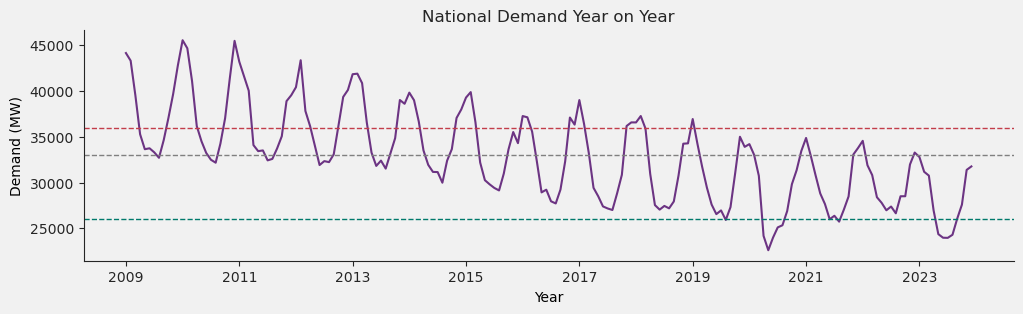

In [103]:
# y5 = sns.lineplot(dfc.groupby("settlement_date")["nd"].agg(["mean"]))
mean_nd_per_mo = dfc.groupby("year_month")["tsd"].agg(["mean"])
mean_mean_nd_per_mo = dfc.groupby("year_month")["tsd"].agg(["mean"]).mean().iloc[0]
mean2023_mean_nd_per_mo = dfc[dfc.year==2023]['nd'].mean()
mean2009_mean_nd_per_mo = dfc[dfc.year==2009]['nd'].mean()

plt.figure(figsize=(12, 3))
fig30 = sns.lineplot(mean_nd_per_mo)
plt.title("National Demand Year on Year")
plt.ylabel("Demand (MW)")
plt.xlabel("Year")
plt.xticks(ticks=['2009-01', '2011-01','2013-01',
                  '2015-01', '2017-01',
                  '2019-01', '2021-01', '2023-01'], 
           labels=[2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023])
plt.legend().remove()
plt.axhline(y=mean_mean_nd_per_mo, c='grey', ls='--', lw=1)
plt.axhline(y=mean2023_mean_nd_per_mo, c=pigeon[1], ls='--', lw=1)
plt.axhline(y=mean2009_mean_nd_per_mo, c=pigeon[2], ls='--', lw=1)
plt.savefig('exports/nd_yoy_by_mo');

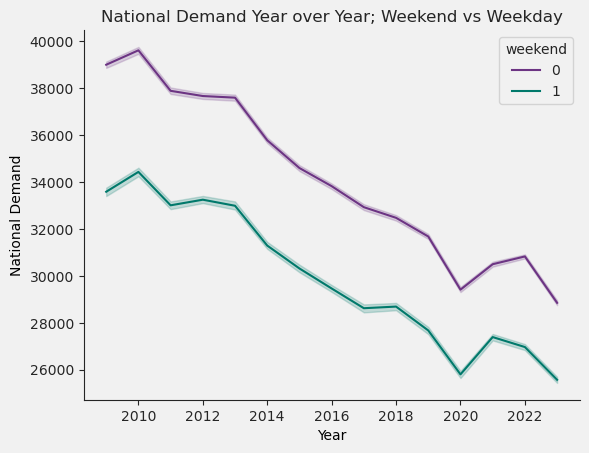

In [104]:
#we use more energy on weekdays!
plt.figure()
fig31 = sns.lineplot(dfc, x="year", hue="weekend", y="tsd").set(title="National Demand Year over Year; Weekend vs Weekday", xlabel="Year", ylabel="National Demand")

<Axes: xlabel='date', ylabel='nd'>

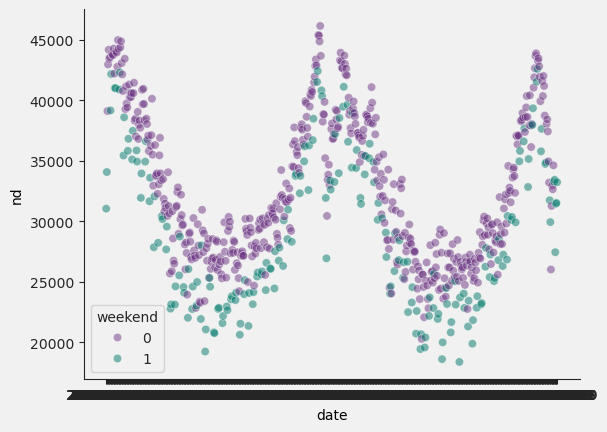

In [105]:
#how is it spread across weekends vs weekdays - let's look at 5pm only
dfc_5pm_2022_2023 = dfc[(dfc.period==35) & (dfc.year>=2022)]

plt.figure()
sns.scatterplot(data=dfc_5pm_2022_2023, y='nd', x='date', hue='weekend', alpha=0.5)

<Figure size 640x480 with 0 Axes>

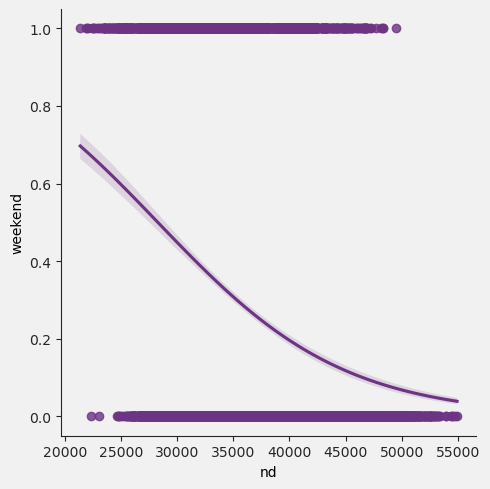

In [106]:
plt.figure()
fig32 = sns.lmplot(data=dfc[dfc.period==40], x="nd", y="weekend", x_jitter=0.2, logistic=True, n_boot=1000);


Tthis lm plot shows you can use national demand to understand if it's a weekend

In [107]:
dfc.head(1)

date                   dt  period    tsd     nd  eng_wal_demand  scot_demand  wind_generation  wind_capacity  solar_generation  solar_capacity  non_bm_stor  pump  ifa_flow  ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  eleclink_flow  in_flow  out_flow  total_flow  france_flow  non_fr_flow  ioi_flow  scottish_transfer  year  month  day   weekday  hour  minute      time year_month  weekend  is_spring  is_summer  is_autumn  is_winter  season  6_hr_period  4_hr_period  3_hr_period  is_hol
0  2009-01-01  2009-01-01 00:00:00       1  38704  37910           33939         3971               54           1403                 0               0            0    33      2002          0             0        -161               0          0       NaN            NaN   2002.0     161.0      1841.0       2002.0       2002.0      -161                NaN  2009      1    1  Thursday     0       0  00:00:00    2009-01        0          0          0          0          1  winter            1            1            1       1

In [108]:
# put weekdays in order
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
wkday_nums = [1, 2, 3, 4, 5, 6, 7]
wkday_order_dict = dict(zip(weekdays, wkday_nums))

#create df showing mean national demand per weekday
nd_by_wkdy = dfc.groupby('weekday')['nd'].mean()

nd_by_wkdy = nd_by_wkdy.reset_index()
nd_by_wkdy['day_order'] = nd_by_wkdy.weekday.map(wkday_order_dict)
nd_by_wkdy = nd_by_wkdy.set_index(keys='day_order').sort_index()

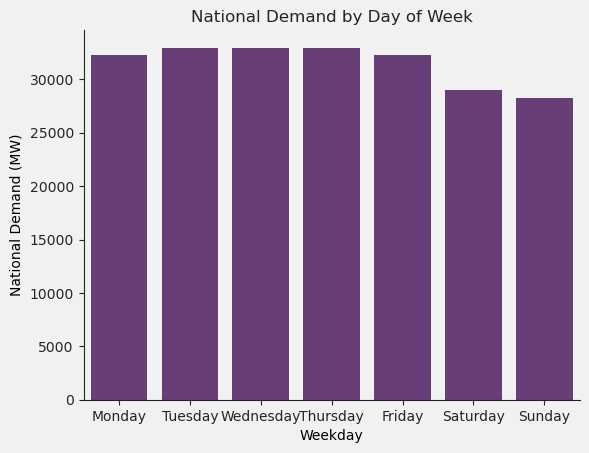

In [109]:
plt.figure()
fig33 = sns.barplot(data=nd_by_wkdy, x='weekday', y='nd')
plt.title('National Demand by Day of Week')
plt.ylabel('National Demand (MW)')
plt.xlabel('Weekday');

National demand is higher on weekdays than weekends, with Tues-Thurs being slightly higher than Monday & Friday. National demand is lowest on a Sunday.